### Saliva data analysis

Analysis of saliva data (combined threshold and validation datasets) to determine if training an ML model with multiple assays performs better than the individual assays

In [1]:
import copy
import pprint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from imblearn.pipeline import Pipeline
from mlxtend.evaluate import combined_ftest_5x2cv
from scipy.stats import boxcox, gaussian_kde, shapiro
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from statsmodels.stats.diagnostic import lilliefors

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('ThresholdValidation_All_Data_NormThresholds.csv')

In [3]:
df.columns

Index(['Plate', 'Thr_ID', 'Val_ID', 'VAL_ID2', 'PP_ID', 'Sample_ID', 'V',
       'SampleID_V', 'Sex', 'Age_years', 'Adult_child', 'Covid_symptoms',
       'Covid_status', 'Donor', 'Donor2', 'Days_postsymptom_onset', 'Status',
       'Sample_set', 'Deposit_application', 'Sample_location', 'Day_of_birth',
       'Month_of_birth', 'Year of birth', 'DoB', 'Sampling_year',
       'Sample_date', 'Sample_type', 'Visit', 'Date_symptom_onset',
       'Date_symptom_resolution', 'Sample notes', 'Family',
       'Experiment_sample_set', 'Sample collection', 'Sample collection2',
       'Samplecollection3', 'WithinPlate_Rep', 'Dilution', 'Antigen',
       'Secondary', 'OD', 'meanOD', 'S1', 'meanS1', 'Norm_OD', 'Conc_unitsml',
       'Conc', 'y', 'x.025', 'x', 'x.975', 'Dilution_numeric',
       'OD_Int.x.unitml', 'AUC', 'Norm_AUC', 'NormThr_97per', 'NormThr_98per',
       'NormThr_99per', 'NormThr_Youd'],
      dtype='object')

In [4]:
keep_cols = ['Thr_ID', 'Val_ID', 'PP_ID', 'Sample_ID', 'V', 'SampleID_V', 'Sex', 'Age_years', 'Adult_child',
             'Covid_symptoms', 'Covid_status', 'Donor', 'Donor2', 'Days_postsymptom_onset', 'Status',
             'Sample_set', 'Visit', 'Family', 'WithinPlate_Rep', 'Dilution', 'Antigen', 'Secondary', 'Norm_OD']

In [5]:
df = df[keep_cols]

In [6]:
df.shape

(4135, 23)

There is quite a lot of variation in the number of repeats and different dilutions run for the individual samples, so checks for an expected number of repeats or dilutions won't help to identify erroneous samples. However, in general expect threshold dataset to have four different dilutions (with no replicates of those dilutions) for each sample, expect validation dataset to have a single dilution with two replicates of that dilution.

FYI there are instances of multiple samples from the same individual in this dataset (because they donated on more than one occasion) - need to identify these repeats and discard them, since violate ML assumption that samples are independent.

In [7]:
# Are there any samples with both a threshold ID and a validation ID / neither ID?
for n in range(df.shape[0]):
    thr_id = df['Thr_ID'][n]
    val_id = df['Val_ID'][n]
    if (   (type(thr_id) != np.float64 and type(val_id) != np.float64)
        or (type(thr_id) == np.float64 and type(val_id) == np.float64)
    ):
        print(thr_id, val_id)
# In no cases does a sample have both a threshold and a validation set ID / neither ID.

In [8]:
# Are there any samples without a sample ID?
for n in range(df.shape[0]):
    sample_id = df['Sample_ID'][n]
    if type(sample_id) == np.float64:
        if np.isnan(sample_id):
            print('NaN ID: {}'.format(n))
# In no cases does a sample have a sample ID of NaN

In [9]:
# Are there any repeated sample IDs?
print('Repeated sample IDs:')
print(len(df['Sample_ID'].tolist()) == len(set(df['Sample_ID'].tolist())))
# Yes, there are repeated sample IDs, since there are multiple dilutions / replicates for each sample

# Are there any samples where PP_ID != Sample_ID?
pp_ids = {}
sample_ids = {}
for n in range(df.shape[0]):
    pp_id = df['PP_ID'][n]
    sample_id = df['Sample_ID'][n]
    if not pp_id in pp_ids:
        pp_ids[pp_id] = []
    if not sample_id in sample_ids:
        sample_ids[sample_id] = []
    if not sample_id in pp_ids[pp_id]:
        pp_ids[pp_id].append(sample_id)
    if not pp_id in sample_ids[sample_id]:
        sample_ids[sample_id].append(pp_id)

print('\n\nInstances where more than one Sample_ID for a particular PP_ID:')
for pp_id, sample_id_list in pp_ids.items():
    if len(sample_id_list) != 1:
        print('{}: {}'.format(pp_id, sample_id_list))
print('\n\nInstances where more than one PP_ID for a particular Sample_ID:')
for sample_id, pp_id_list in sample_ids.items():
    if len(pp_id_list) != 1:
        print('{}: {}'.format(sample_id, pp_id_list))
# In most cases, PP_ID is NaN => multiple sample IDs corresponding to PP_ID = NaN. However, in the cases where
# PP_ID != NaN, there are no PP_IDs that correspond to more than one sample ID.
# There are two instances where one sample ID corresponds to two PP_IDs, in both cases a "real" PP_ID and NaN.
# Consequently, will use Sample_ID, but not PP_ID, to distinguish between individuals

Repeated sample IDs:
False


Instances where more than one Sample_ID for a particular PP_ID:
nan: ['612', '66', '600', '597', '723', '688', '683', '689', '690', '601', '691', '603', '696', '725', '596', 'AG02', '642', '611', 'PR10', '663', 'AT12', '606', 'PL33TL', '654', 'PL19OS', '638', 'PL46JI', '671', 'PL21RK', '631', 'PL57JM', 'RW03', '653', 'Q1RC14', '636', 'KN01', '672', '667', '584', 'PL20DL', '724', 'PL39RS', '588', 'PL17HB', '595', 'PL11AP', '647', 'EH05', '605', 'PL36KS', 'PL38IS', '574', '620', 'PL41AC', 'PL18DW', 'PL37MS', 'PL42OJ', 'PL22OJ', 'PL45SA', '583', '586', 'PL24SB', '593', 'PL55MC', 'PL40RW', 'PL35EM', 'PL59DC', '276', 'PL48JP', '241', '572', '274', '640', '264', '626', '266', 'Q1DL20', 'PL47RD', '235', 'AJ18', 'AM06', '282', 'PL49FH', '682', '613', '199', '243', '608', 'AV04', 'CH07', '95', 'Q1CC08', '670', '633', 'PL52ST', '900', '646', 'PL56JH', '604', '614', '610', '278', '602', '258', 'SS14', '291', 'Q1CE24', 'PL54LH', '247', '239', '249', 'PH13', '287', 'CC0

In [10]:
# Are there any repeated combined sample IDs and dilutions?
sample_repeats = []
for n in range(df.shape[0]):
    sample_repeats.append('{}_{}_{}_{}_{}_{}'.format(
        df['Sample_ID'][n], df['V'][n], df['WithinPlate_Rep'][n], df['Dilution'][n], df['Antigen'][n],
        df['Secondary'][n]
    ))
print(len(sample_repeats) == len(set(sample_repeats)))
# So, each sample can be individually identified by:
# - "Sample_ID" = patient ID
# - "V" = visit number?
# - "WithinPlate_Rep" = Is there another technical replicate of this sample?
# - "Dilution" = Sample dilution
# - "Antigen" = Spike, RBD or N-protein
# - "Secondary" = IgA or IgG

True


In [11]:
# Need to restructure dataframe so that each row corresponds to a single sample, different antigens/secondary
# antibodies, dilutions are repeats are separated into different columns (rather than different rows as is the
# case in the csv file)
comb_sample_info = ['{}_{}_{}_{}'.format(df['Antigen'][n], df['Secondary'][n], df['WithinPlate_Rep'][n],
                                         df['Dilution'][n]) for n in range(df.shape[0])]
df['Patient'] = comb_sample_info

reshaped_df = df.pivot(index=['SampleID_V', 'Sex', 'Age_years', 'Adult_child', 'Covid_symptoms', 'Covid_status'],
                       columns='Patient', values='Norm_OD')
reshaped_df = reshaped_df.reset_index()

In [12]:
reshaped_df

Patient,SampleID_V,Sex,Age_years,Adult_child,Covid_symptoms,Covid_status,N-protein_IgA_1.0_10,N-protein_IgA_1.0_2430,N-protein_IgA_1.0_270,N-protein_IgA_1.0_30,...,Spike_IgA_1.0_90,Spike_IgA_nan_10,Spike_IgG_1.0_10,Spike_IgG_1.0_160,Spike_IgG_1.0_20,Spike_IgG_1.0_320,Spike_IgG_1.0_40,Spike_IgG_1.0_5,Spike_IgG_1.0_80,Spike_IgG_nan_5
0,137_V1,M,2.0,Child,NaN,Pre-pandemic,NaN,NaN,NaN,NaN,...,0.015229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,138_V1,M,2.0,Child,NaN,Pre-pandemic,NaN,NaN,NaN,NaN,...,0.001585,NaN,0.019727,NaN,0.011297,NaN,0.007924,0.033553,NaN,NaN
2,147_V1,F,1.0,Child,NaN,Pre-pandemic,NaN,NaN,NaN,NaN,...,NaN,0.031478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,183_V1,F,4.0,Child,NaN,Pre-pandemic,NaN,NaN,NaN,NaN,...,NaN,0.071429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.134303
4,190_V1,F,4.0,Child,NaN,Pre-pandemic,NaN,NaN,NaN,NaN,...,NaN,0.049465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,RW03_V2,F,25.0,Adult,NaN,Pre-pandemic,0.383812,NaN,0.023024,0.139805,...,0.080654,NaN,0.031205,NaN,0.019887,NaN,0.011156,0.055780,NaN,NaN
340,RW03_V3,F,25.0,Adult,NaN,Pre-pandemic,NaN,NaN,NaN,NaN,...,NaN,0.296574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.081259
341,RW03_V4,F,25.0,Adult,NaN,Pre-pandemic,0.409918,NaN,0.016696,0.158734,...,0.043739,NaN,0.057449,NaN,0.033775,NaN,0.018939,0.100379,NaN,NaN
342,SS14_V3,F,23.0,Adult,NaN,Pre-pandemic,NaN,NaN,NaN,NaN,...,NaN,0.342756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.145154


In [13]:
# Only want to work with a single dilution per assay => select dilution with the most information available for
# each assay
for col in reshaped_df.columns:
    if not col in ['SampleID_V', 'Sex', 'Age_years', 'Adult_child', 'Covid_symptoms', 'Covid_status']:
        num_non_nan = len([x for x in reshaped_df[col].tolist() if not np.isnan(x)])
        print('{}:   {}'.format(col, num_non_nan))

N-protein_IgA_1.0_10:   138
N-protein_IgA_1.0_2430:   10
N-protein_IgA_1.0_270:   138
N-protein_IgA_1.0_30:   138
N-protein_IgA_1.0_7290:   10
N-protein_IgA_1.0_810:   10
N-protein_IgA_1.0_90:   138
N-protein_IgA_nan_10:   138
N-protein_IgG_1.0_10:   136
N-protein_IgG_1.0_160:   10
N-protein_IgG_1.0_20:   137
N-protein_IgG_1.0_320:   10
N-protein_IgG_1.0_40:   137
N-protein_IgG_1.0_5:   137
N-protein_IgG_1.0_80:   10
N-protein_IgG_nan_5:   138
RBD_IgA_1.0_10:   117
RBD_IgA_1.0_2430:   10
RBD_IgA_1.0_270:   117
RBD_IgA_1.0_30:   117
RBD_IgA_1.0_7290:   10
RBD_IgA_1.0_810:   10
RBD_IgA_1.0_90:   117
RBD_IgG_1.0_10:   114
RBD_IgG_1.0_160:   10
RBD_IgG_1.0_20:   114
RBD_IgG_1.0_320:   10
RBD_IgG_1.0_40:   114
RBD_IgG_1.0_5:   115
RBD_IgG_1.0_80:   10
Spike_IgA_1.0_10:   176
Spike_IgA_1.0_2430:   10
Spike_IgA_1.0_270:   176
Spike_IgA_1.0_30:   176
Spike_IgA_1.0_7290:   10
Spike_IgA_1.0_810:   10
Spike_IgA_1.0_90:   176
Spike_IgA_nan_10:   159
Spike_IgG_1.0_10:   163
Spike_IgG_1.0_160:   10


So, based upon the above numbers, selected dilutions are:
- N/IgA = 10, 30, 90, 270 - all dilutions have 138 values, select one of these dilutions based upon performance
- N/IgG = 5, 10, 20, 40 - all dilutions have 136/137 values, select one of these dilutions based upon performance
- RBD/IgA = 10, 30, 90, 270 - all dilutions have 117 values, select one of these dilutions based upon performance
- RBD/IgG = 5, 10, 20, 40 - all dilutions have 114/115 values, select one of these dilutions based upon performance
- Spike/IgA = 10, 30, 90, 270 - all dilutions have 176 values, select one of these dilutions based upon performance
- Spike/IgG = 5, 10, 20, 40 - all dilutions have 162/163 values, select one of these dilutions based upon performance

In [14]:
# Filter dataframe to remove dilutions not listed above
keep_cont_cols = ['N-protein_IgA_1.0_10', 'N-protein_IgA_1.0_30', 'N-protein_IgA_1.0_90', 'N-protein_IgA_1.0_270',
                  'N-protein_IgG_1.0_5', 'N-protein_IgG_1.0_10', 'N-protein_IgG_1.0_20', 'N-protein_IgG_1.0_40',
                  'RBD_IgA_1.0_10', 'RBD_IgA_1.0_30', 'RBD_IgA_1.0_90', 'RBD_IgA_1.0_270',
                  'RBD_IgG_1.0_5', 'RBD_IgG_1.0_10', 'RBD_IgG_1.0_20', 'RBD_IgG_1.0_40',
                  'Spike_IgA_1.0_10', 'Spike_IgA_1.0_30', 'Spike_IgA_1.0_90', 'Spike_IgA_1.0_270',
                  'Spike_IgG_1.0_5', 'Spike_IgG_1.0_10', 'Spike_IgG_1.0_20', 'Spike_IgG_1.0_40']
keep_disc_cols = ['SampleID_V', 'Sex', 'Age_years', 'Adult_child', 'Covid_symptoms', 'Covid_status']
reshaped_df = reshaped_df[keep_cont_cols + keep_disc_cols]

In [15]:
reshaped_df

Patient,N-protein_IgA_1.0_10,N-protein_IgA_1.0_30,N-protein_IgA_1.0_90,N-protein_IgA_1.0_270,N-protein_IgG_1.0_5,N-protein_IgG_1.0_10,N-protein_IgG_1.0_20,N-protein_IgG_1.0_40,RBD_IgA_1.0_10,RBD_IgA_1.0_30,...,Spike_IgG_1.0_5,Spike_IgG_1.0_10,Spike_IgG_1.0_20,Spike_IgG_1.0_40,SampleID_V,Sex,Age_years,Adult_child,Covid_symptoms,Covid_status
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,137_V1,M,2.0,Child,NaN,Pre-pandemic
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.033553,0.019727,0.011297,0.007924,138_V1,M,2.0,Child,NaN,Pre-pandemic
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,147_V1,F,1.0,Child,NaN,Pre-pandemic
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,183_V1,F,4.0,Child,NaN,Pre-pandemic
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,190_V1,F,4.0,Child,NaN,Pre-pandemic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,0.383812,0.139805,0.053881,0.023024,0.064146,0.046464,0.026147,0.021633,0.666354,0.285759,...,0.055780,0.031205,0.019887,0.011156,RW03_V2,F,25.0,Adult,NaN,Pre-pandemic
340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,RW03_V3,F,25.0,Adult,NaN,Pre-pandemic
341,0.409918,0.158734,0.049589,0.016696,0.219718,0.127465,0.107746,0.038028,0.515562,0.232666,...,0.100379,0.057449,0.033775,0.018939,RW03_V4,F,25.0,Adult,NaN,Pre-pandemic
342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,SS14_V3,F,23.0,Adult,NaN,Pre-pandemic


In [16]:
# Count instances of different statuses ('Pre-pandemic', 'PCR confirmed', etc.)
pre_pandemic = reshaped_df['Covid_status'].tolist().count('Pre-pandemic')
pcr_confirmed = reshaped_df['Covid_status'].tolist().count('PCR confirmed')
antibody_confirmed = reshaped_df['Covid_status'].tolist().count('Antibody confirmed')
healthy_donor = reshaped_df['Covid_status'].tolist().count('Healthy donor')
suspected = reshaped_df['Covid_status'].tolist().count('Suspected')
unconfirmed = reshaped_df['Covid_status'].tolist().count('Unconfirmed')
pcr_negative_contact = reshaped_df['Covid_status'].tolist().count('PCR negative contact')
pcr_negative_sympt = reshaped_df['Covid_status'].tolist().count('PCR negative, symptomatic')
print('Pre-pandemic: {}'.format(pre_pandemic))
print('PCR confirmed: {}'.format(pcr_confirmed))
print('Antibody confirmed: {}'.format(antibody_confirmed))
print('Healthy donor: {}'.format(healthy_donor))
print('Suspected: {}'.format(suspected))
print('Unconfirmed: {}'.format(unconfirmed))
print('PCR negative contact: {}'.format(pcr_negative_contact))
print('PCR negative, symptomatic: {}'.format(pcr_negative_sympt))
total = (pre_pandemic + pcr_confirmed + antibody_confirmed + healthy_donor + suspected + unconfirmed
         + pcr_negative_contact + pcr_negative_sympt)
print('Total labelled samples: {}'.format(total))
print('Unlabelled samples: {}'.format(reshaped_df.shape[0] - total))

Pre-pandemic: 229
PCR confirmed: 89
Antibody confirmed: 3
Healthy donor: 7
Suspected: 7
Unconfirmed: 4
PCR negative contact: 2
PCR negative, symptomatic: 3
Total labelled samples: 344
Unlabelled samples: 0


In [17]:
# Discard samples that aren't  "Pre-pandemic" or "PCR confirmed" (so all samples are definite negatives/positives)
reshaped_df = reshaped_df[
    reshaped_df['Covid_status'].isin(['Pre-pandemic', 'PCR confirmed'])
].reset_index(drop=True)
reshaped_df

Patient,N-protein_IgA_1.0_10,N-protein_IgA_1.0_30,N-protein_IgA_1.0_90,N-protein_IgA_1.0_270,N-protein_IgG_1.0_5,N-protein_IgG_1.0_10,N-protein_IgG_1.0_20,N-protein_IgG_1.0_40,RBD_IgA_1.0_10,RBD_IgA_1.0_30,...,Spike_IgG_1.0_5,Spike_IgG_1.0_10,Spike_IgG_1.0_20,Spike_IgG_1.0_40,SampleID_V,Sex,Age_years,Adult_child,Covid_symptoms,Covid_status
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,137_V1,M,2.0,Child,NaN,Pre-pandemic
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.033553,0.019727,0.011297,0.007924,138_V1,M,2.0,Child,NaN,Pre-pandemic
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,147_V1,F,1.0,Child,NaN,Pre-pandemic
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,183_V1,F,4.0,Child,NaN,Pre-pandemic
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,190_V1,F,4.0,Child,NaN,Pre-pandemic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,0.383812,0.139805,0.053881,0.023024,0.064146,0.046464,0.026147,0.021633,0.666354,0.285759,...,0.055780,0.031205,0.019887,0.011156,RW03_V2,F,25.0,Adult,NaN,Pre-pandemic
314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,RW03_V3,F,25.0,Adult,NaN,Pre-pandemic
315,0.409918,0.158734,0.049589,0.016696,0.219718,0.127465,0.107746,0.038028,0.515562,0.232666,...,0.100379,0.057449,0.033775,0.018939,RW03_V4,F,25.0,Adult,NaN,Pre-pandemic
316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,SS14_V3,F,23.0,Adult,NaN,Pre-pandemic


In [18]:
def calc_kde_overlap(negative_df, positive_df, col, x_min, x_max):
    # Code below taken from https://stackoverflow.com/questions/20381672/calculate-overlap-area-of-two-functions
    x_pts = np.mgrid[x_min:x_max:1000j]
    neg_kernel = gaussian_kde(negative_df[col], bw_method='scott', weights=None)
    pos_kernel = gaussian_kde(positive_df[col], bw_method='scott', weights=None)
    neg_kde = np.reshape(neg_kernel(x_pts).T, x_pts.shape)
    pos_kde = np.reshape(pos_kernel(x_pts).T, x_pts.shape)
    overlap = 0

    for index, pt in np.ndenumerate(x_pts):
        index = index[0]
        if index != (x_pts.shape[0] - 1):
            y1_neg = neg_kde[index]
            y2_neg = neg_kde[index+1]
            y1_pos = pos_kde[index]
            y2_pos = pos_kde[index+1]
            height = x_pts[index+1] - x_pts[index]

            if y1_pos <= y1_neg and y2_pos <= y2_neg:
                area = ((y1_pos + y2_pos)*0.5*height)
            elif y1_pos >= y1_neg and y2_pos >= y2_neg:
                area = ((y1_neg + y2_neg)*0.5*height)
            else:
                area = 0
            overlap += area
            
    return overlap

Antigen: N-protein
Secondary antibody: IgA
Dilution: 1 in 10


<Figure size 432x288 with 0 Axes>

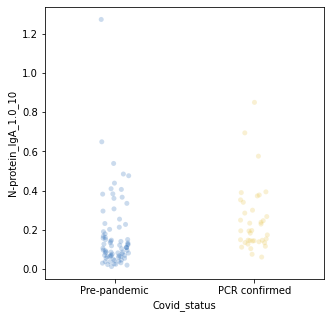

<Figure size 432x288 with 0 Axes>

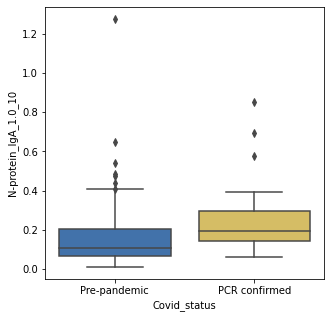

<Figure size 432x288 with 0 Axes>

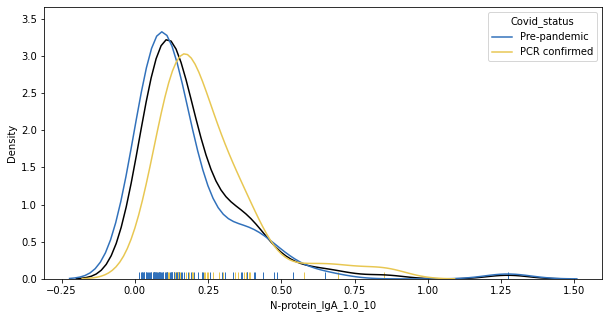

KDE overlap: 0.7259591350353948



Antigen: N-protein
Secondary antibody: IgA
Dilution: 1 in 30


<Figure size 432x288 with 0 Axes>

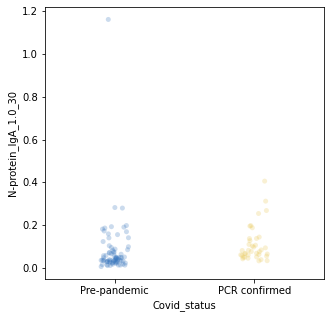

<Figure size 432x288 with 0 Axes>

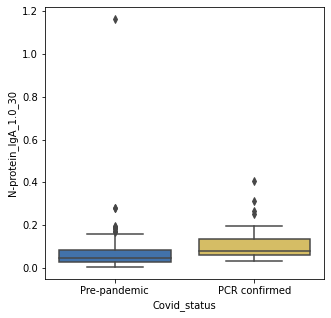

<Figure size 432x288 with 0 Axes>

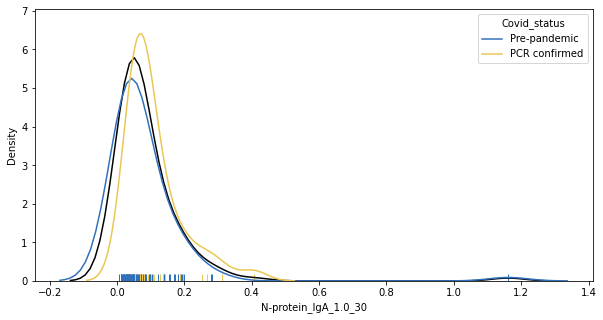

KDE overlap: 0.7803765702396808



Antigen: N-protein
Secondary antibody: IgA
Dilution: 1 in 90


<Figure size 432x288 with 0 Axes>

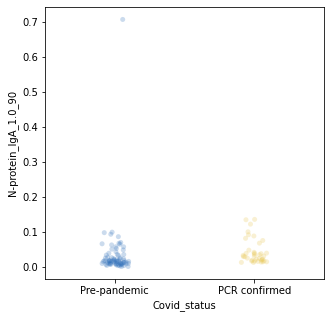

<Figure size 432x288 with 0 Axes>

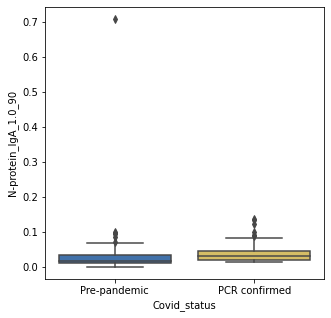

<Figure size 432x288 with 0 Axes>

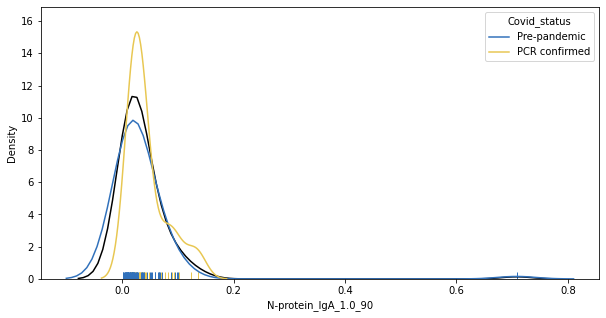

KDE overlap: 0.7438035982517047



Antigen: N-protein
Secondary antibody: IgA
Dilution: 1 in 270


<Figure size 432x288 with 0 Axes>

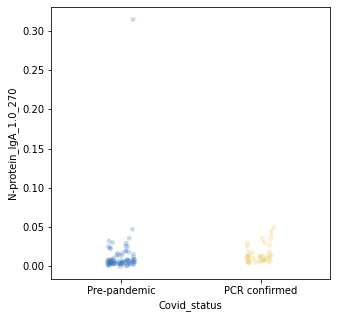

<Figure size 432x288 with 0 Axes>

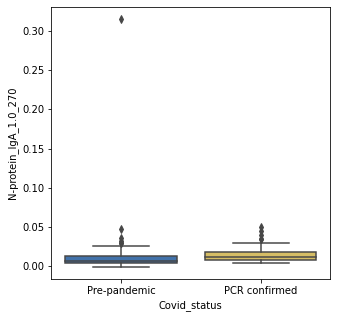

<Figure size 432x288 with 0 Axes>

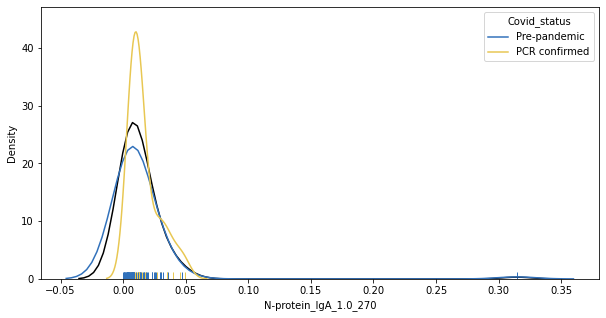

KDE overlap: 0.7004231055934098



Antigen: N-protein
Secondary antibody: IgG
Dilution: 1 in 5


<Figure size 432x288 with 0 Axes>

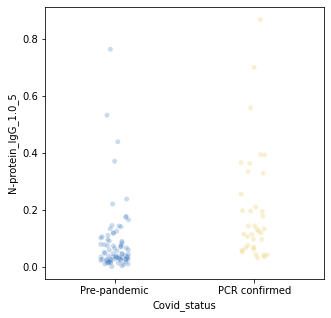

<Figure size 432x288 with 0 Axes>

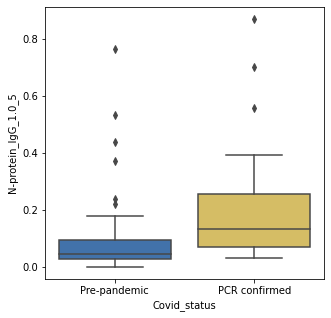

<Figure size 432x288 with 0 Axes>

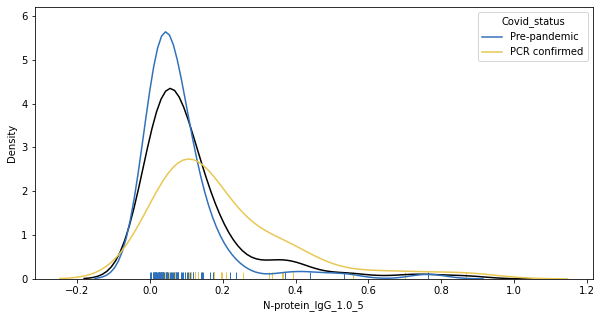

KDE overlap: 0.6180224464293591



Antigen: N-protein
Secondary antibody: IgG
Dilution: 1 in 10


<Figure size 432x288 with 0 Axes>

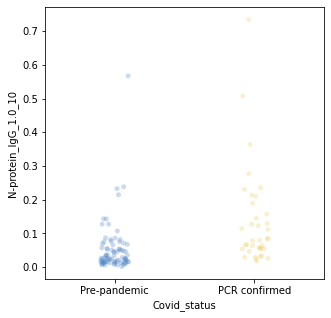

<Figure size 432x288 with 0 Axes>

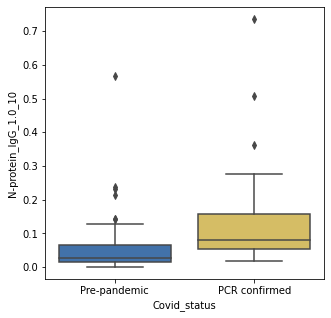

<Figure size 432x288 with 0 Axes>

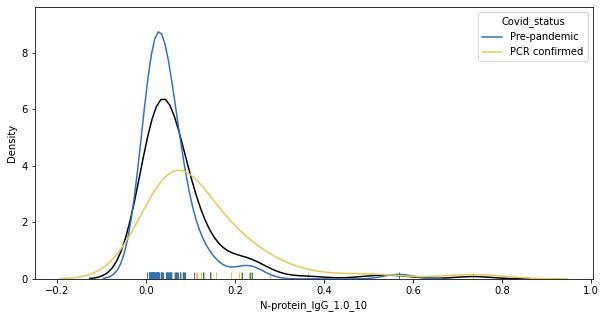

KDE overlap: 0.598056207077124



Antigen: N-protein
Secondary antibody: IgG
Dilution: 1 in 20


<Figure size 432x288 with 0 Axes>

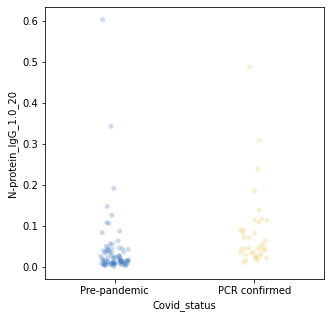

<Figure size 432x288 with 0 Axes>

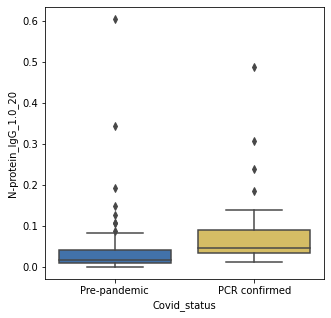

<Figure size 432x288 with 0 Axes>

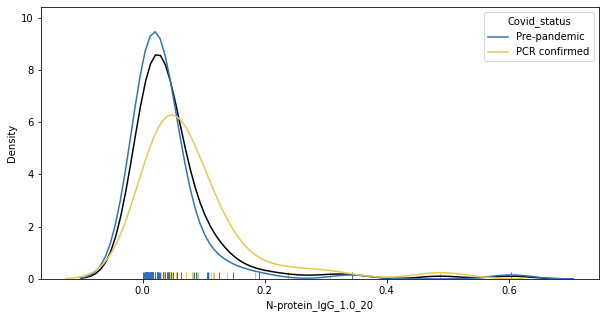

KDE overlap: 0.7055287776087834



Antigen: N-protein
Secondary antibody: IgG
Dilution: 1 in 40


<Figure size 432x288 with 0 Axes>

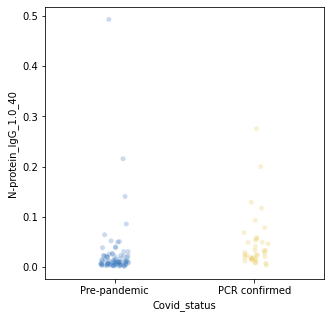

<Figure size 432x288 with 0 Axes>

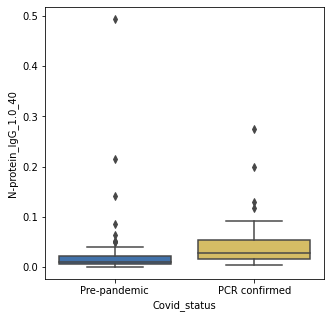

<Figure size 432x288 with 0 Axes>

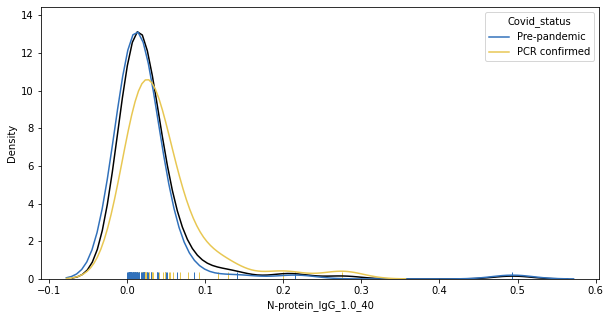

KDE overlap: 0.7557962209625539



Antigen: RBD
Secondary antibody: IgA
Dilution: 1 in 10


<Figure size 432x288 with 0 Axes>

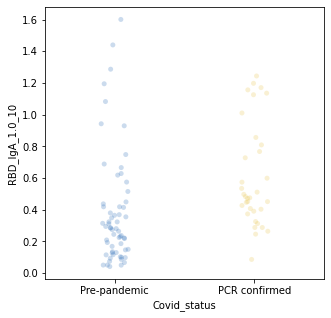

<Figure size 432x288 with 0 Axes>

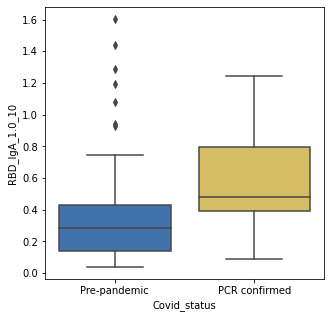

<Figure size 432x288 with 0 Axes>

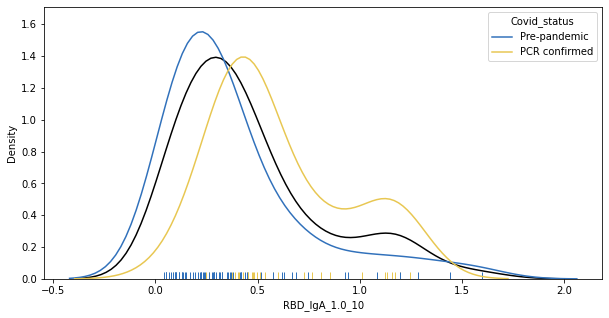

KDE overlap: 0.6557015430421912



Antigen: RBD
Secondary antibody: IgA
Dilution: 1 in 30


<Figure size 432x288 with 0 Axes>

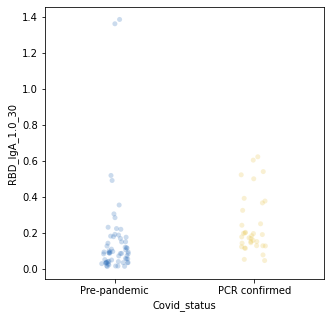

<Figure size 432x288 with 0 Axes>

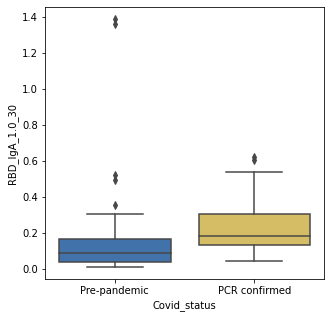

<Figure size 432x288 with 0 Axes>

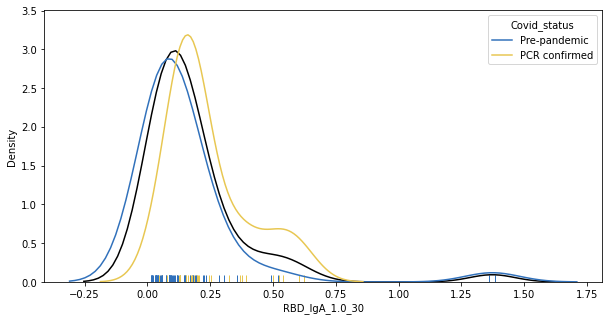

KDE overlap: 0.6829206372508843



Antigen: RBD
Secondary antibody: IgA
Dilution: 1 in 90


<Figure size 432x288 with 0 Axes>

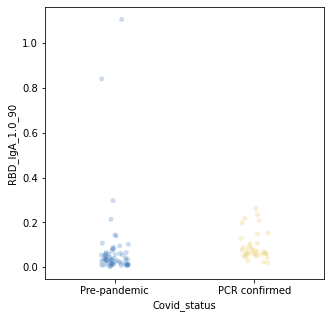

<Figure size 432x288 with 0 Axes>

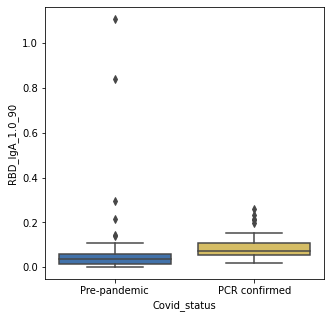

<Figure size 432x288 with 0 Axes>

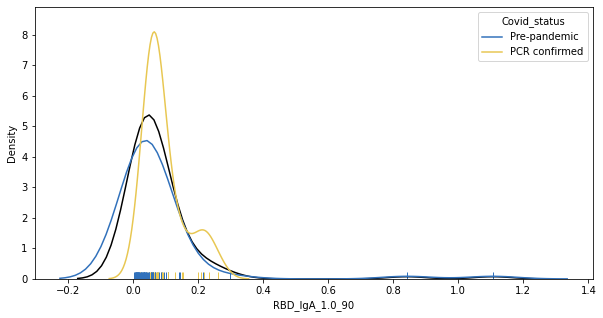

KDE overlap: 0.6676554076537176



Antigen: RBD
Secondary antibody: IgA
Dilution: 1 in 270


<Figure size 432x288 with 0 Axes>

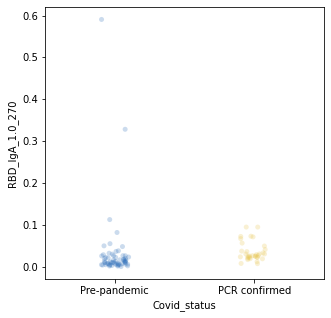

<Figure size 432x288 with 0 Axes>

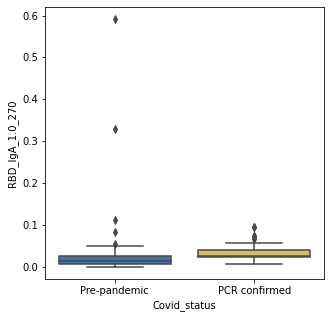

<Figure size 432x288 with 0 Axes>

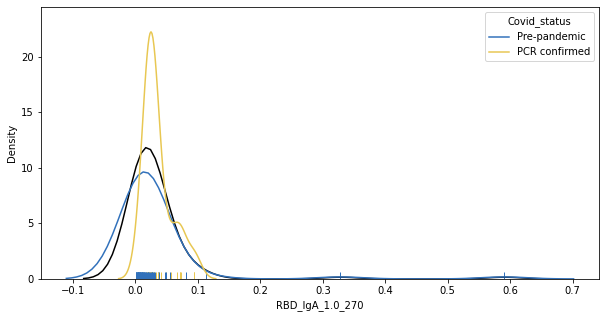

KDE overlap: 0.6224050904497779



Antigen: RBD
Secondary antibody: IgG
Dilution: 1 in 5


<Figure size 432x288 with 0 Axes>

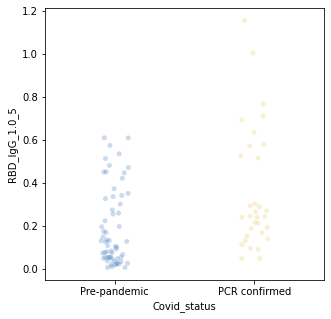

<Figure size 432x288 with 0 Axes>

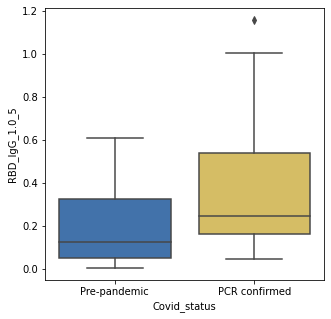

<Figure size 432x288 with 0 Axes>

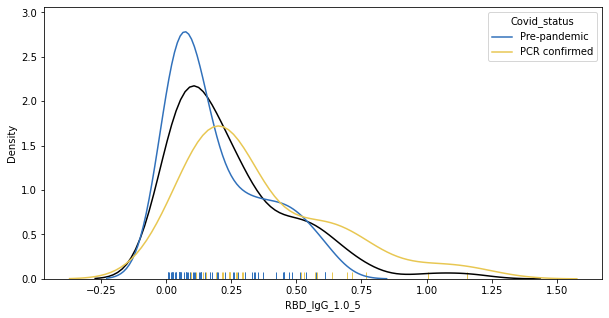

KDE overlap: 0.7131219232799803



Antigen: RBD
Secondary antibody: IgG
Dilution: 1 in 10


<Figure size 432x288 with 0 Axes>

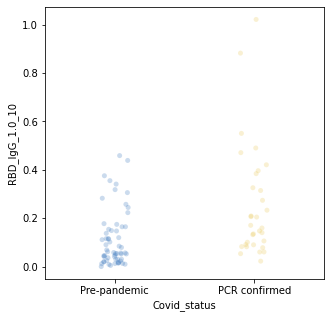

<Figure size 432x288 with 0 Axes>

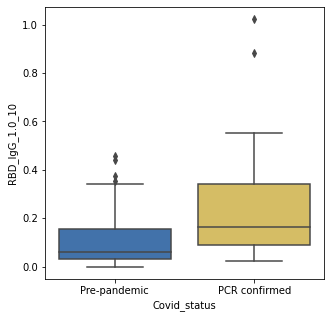

<Figure size 432x288 with 0 Axes>

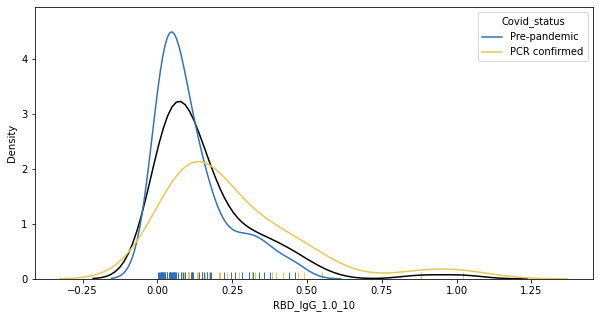

KDE overlap: 0.6525919091734566



Antigen: RBD
Secondary antibody: IgG
Dilution: 1 in 20


<Figure size 432x288 with 0 Axes>

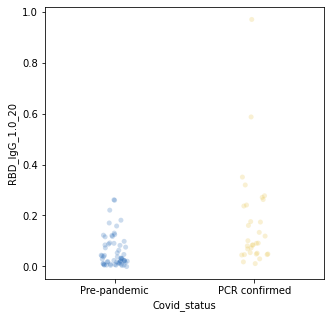

<Figure size 432x288 with 0 Axes>

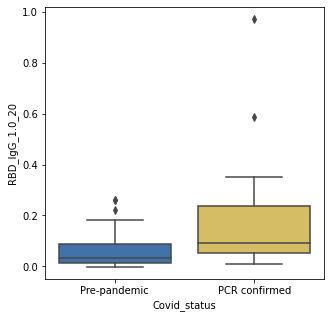

<Figure size 432x288 with 0 Axes>

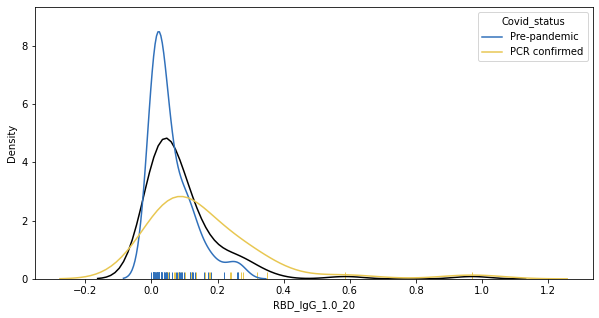

KDE overlap: 0.5655172998406496



Antigen: RBD
Secondary antibody: IgG
Dilution: 1 in 40


<Figure size 432x288 with 0 Axes>

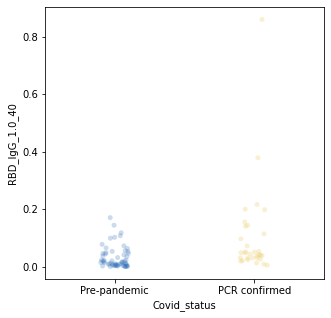

<Figure size 432x288 with 0 Axes>

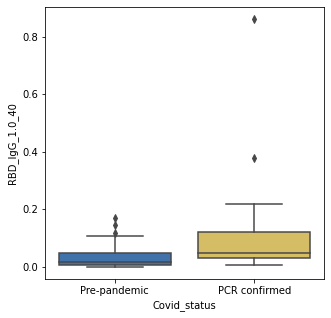

<Figure size 432x288 with 0 Axes>

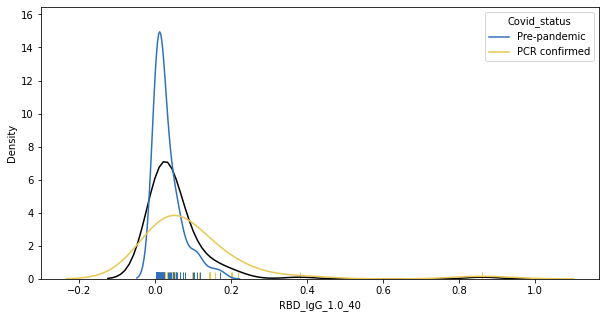

KDE overlap: 0.492170726050277



Antigen: Spike
Secondary antibody: IgA
Dilution: 1 in 10


<Figure size 432x288 with 0 Axes>

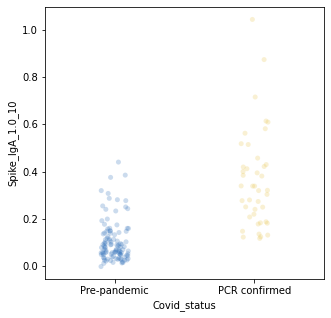

<Figure size 432x288 with 0 Axes>

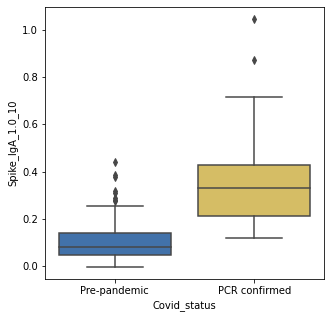

<Figure size 432x288 with 0 Axes>

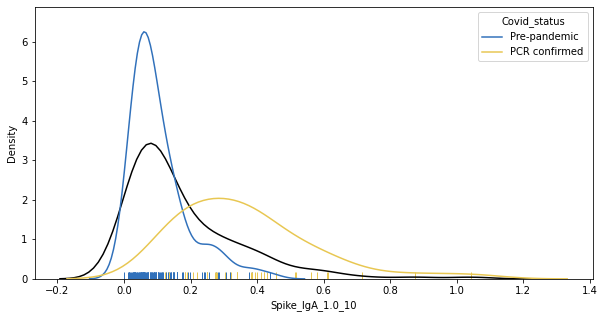

KDE overlap: 0.362924075184585



Antigen: Spike
Secondary antibody: IgA
Dilution: 1 in 30


<Figure size 432x288 with 0 Axes>

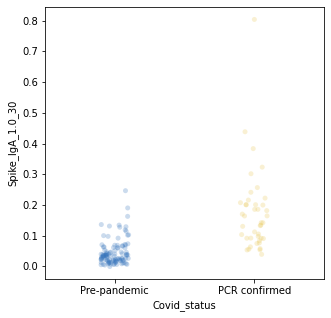

<Figure size 432x288 with 0 Axes>

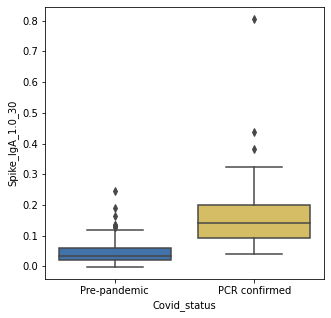

<Figure size 432x288 with 0 Axes>

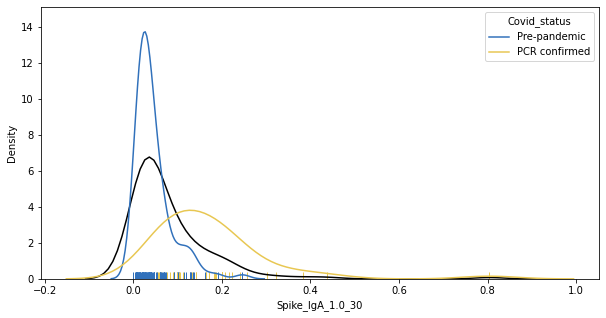

KDE overlap: 0.37854271549313057



Antigen: Spike
Secondary antibody: IgA
Dilution: 1 in 90


<Figure size 432x288 with 0 Axes>

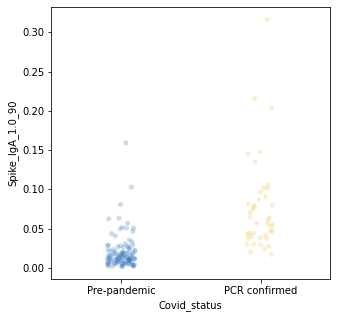

<Figure size 432x288 with 0 Axes>

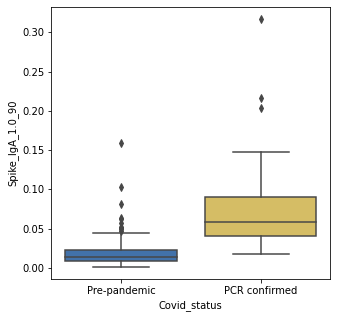

<Figure size 432x288 with 0 Axes>

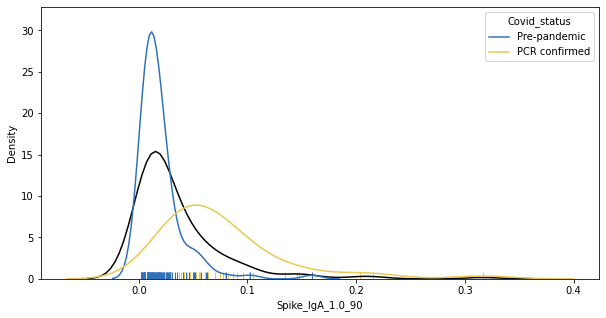

KDE overlap: 0.37608633628071036



Antigen: Spike
Secondary antibody: IgA
Dilution: 1 in 270


<Figure size 432x288 with 0 Axes>

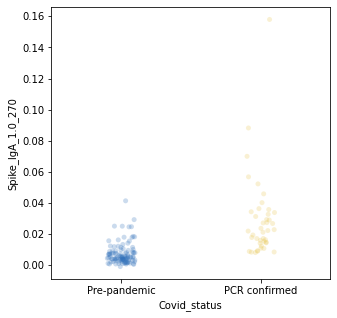

<Figure size 432x288 with 0 Axes>

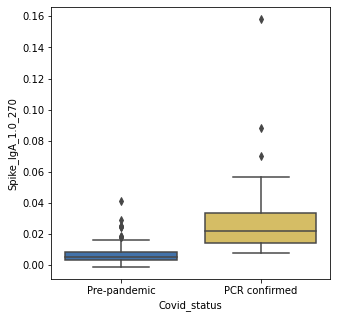

<Figure size 432x288 with 0 Axes>

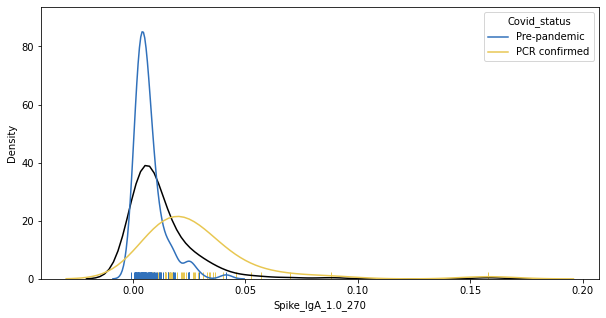

KDE overlap: 0.3768162953471675



Antigen: Spike
Secondary antibody: IgG
Dilution: 1 in 5


<Figure size 432x288 with 0 Axes>

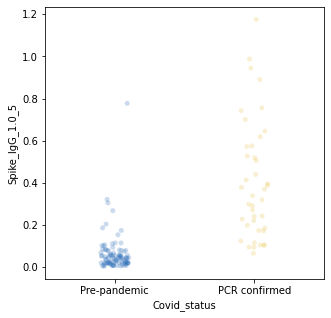

<Figure size 432x288 with 0 Axes>

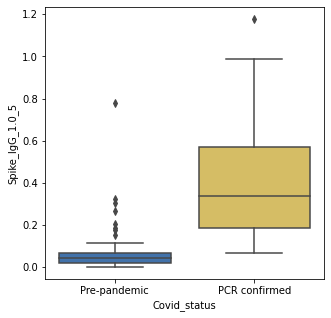

<Figure size 432x288 with 0 Axes>

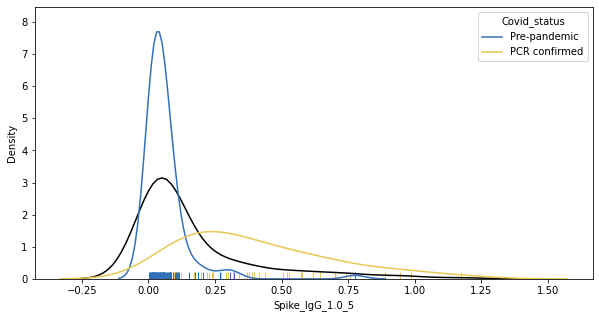

KDE overlap: 0.2740503848176364



Antigen: Spike
Secondary antibody: IgG
Dilution: 1 in 10


<Figure size 432x288 with 0 Axes>

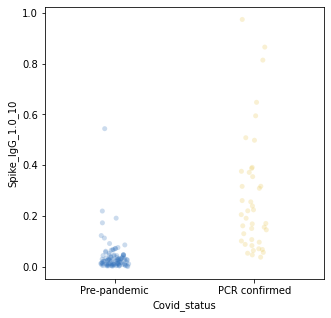

<Figure size 432x288 with 0 Axes>

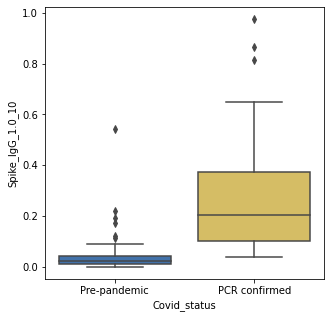

<Figure size 432x288 with 0 Axes>

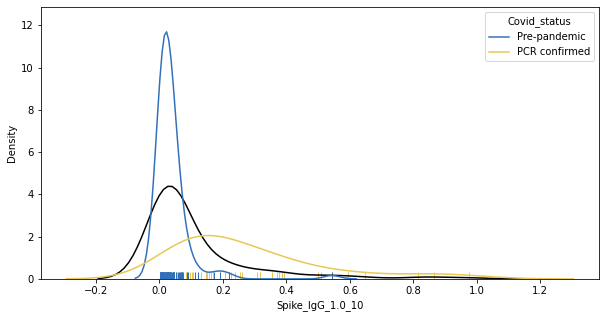

KDE overlap: 0.2788338188836727



Antigen: Spike
Secondary antibody: IgG
Dilution: 1 in 20


<Figure size 432x288 with 0 Axes>

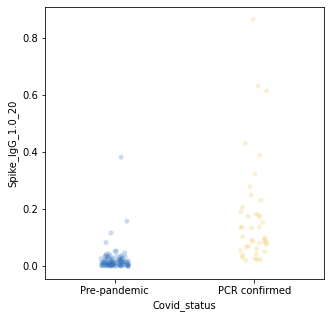

<Figure size 432x288 with 0 Axes>

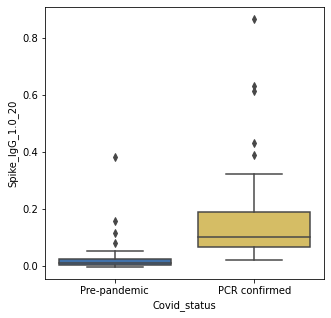

<Figure size 432x288 with 0 Axes>

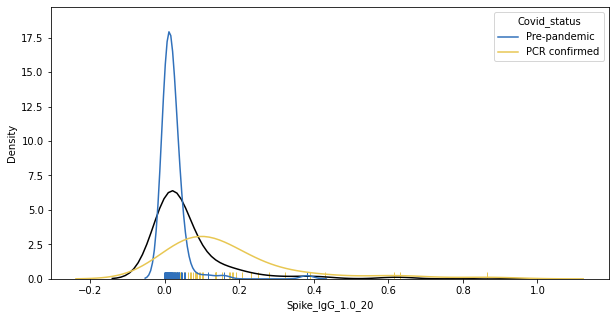

KDE overlap: 0.2723933300657668



Antigen: Spike
Secondary antibody: IgG
Dilution: 1 in 40


<Figure size 432x288 with 0 Axes>

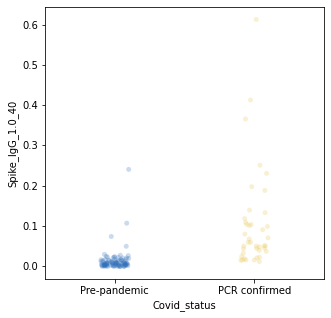

<Figure size 432x288 with 0 Axes>

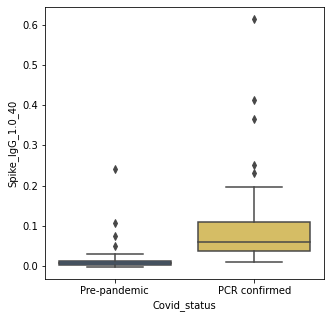

<Figure size 432x288 with 0 Axes>

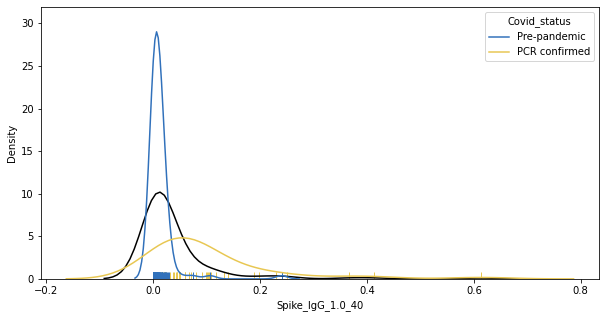

KDE overlap: 0.27807781257979763





In [19]:
# Plot distributions of positive and negative values for each antigen/secondary antibody combination to determine
# which combination gives the best discrimination between positive and negative samples
for col in keep_cont_cols:
    print('Antigen: {}'.format(col.split('_')[0]))
    print('Secondary antibody: {}'.format(col.split('_')[1]))
    print('Dilution: 1 in {}'.format(col.split('_')[3]))

    sub_df = reshaped_df[[col, 'Covid_status']].dropna()

    # Strip plot
    plt.clf()
    plt.figure(figsize=(5, 5))
    sns.stripplot(
        data=sub_df, x='Covid_status', y=col, jitter=True, alpha=0.25, order=['Pre-pandemic', 'PCR confirmed'],
        palette={'Pre-pandemic': '#3171BB', 'PCR confirmed': '#E8C752'}
    )
    plt.show()

    # Box plot
    plt.clf()
    plt.figure(figsize=(5, 5))
    sns.boxplot(
        data=sub_df, x='Covid_status', y=col, order=['Pre-pandemic', 'PCR confirmed'],
        palette={'Pre-pandemic': '#3171BB', 'PCR confirmed': '#E8C752'}
    )
    plt.show()

    # KDE plot
    plt.clf()
    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=sub_df, x=col, color='k', bw_method='scott', gridsize=100, cut=3, clip=None)
    sns.kdeplot(data=sub_df[sub_df['Covid_status']=='Pre-pandemic'].reset_index(drop=True),
                x=col, color='#3171BB', bw_method='scott', gridsize=100, cut=3, clip=None)
    sns.kdeplot(data=sub_df[sub_df['Covid_status']=='PCR confirmed'].reset_index(drop=True),
                x=col, color='#E8C752', bw_method='scott', gridsize=100, cut=3, clip=None)
    sns.rugplot(
        data=sub_df, x=col, hue='Covid_status', hue_order=['Pre-pandemic', 'PCR confirmed'],
        palette={'Pre-pandemic': '#3171BB', 'PCR confirmed': '#E8C752'}
    )
    plt.show()
    
    # Calculate KDE plot overlap
    negative_df = sub_df[sub_df['Covid_status'] == 'Pre-pandemic'].reset_index(drop=True)
    positive_df = sub_df[sub_df['Covid_status'] == 'PCR confirmed'].reset_index(drop=True)
    add_sub = 0.1
    x_vals = [x for x in sub_df[col].tolist() if not np.isnan(x)]
    x_min = min(x_vals) - add_sub
    x_max = max(x_vals) + add_sub
    overlap = calc_kde_overlap(negative_df[[col]], positive_df[[col]], col, x_min, x_max)
    print('KDE overlap: {}\n\n\n'.format(overlap))

Based upon these plots, discrimination between positive and negative samples by each antigen/secondary antibody combination is largely independent of dilution. Consequently, since in some cases discrimination appears slightly better at higher concentrations, and none of the assays appear to have reached saturation at the smallest dilution, will take these assays forwards for my analysis. If needed can look at other dilutions to check that different samples aren't best-separated at different dilutions.

In [20]:
keep_dil_cols = ['N-protein_IgA_1.0_10', 'N-protein_IgG_1.0_5', 'RBD_IgA_1.0_10', 'RBD_IgG_1.0_5',
                 'Spike_IgA_1.0_10', 'Spike_IgG_1.0_5']




N-protein_IgA_1.0_10
Transform: Square root
Significantly different from normal distribution (< 0.05)? 3.8361199633518694e-11
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 7.929428173957476e-10


<Figure size 432x288 with 0 Axes>

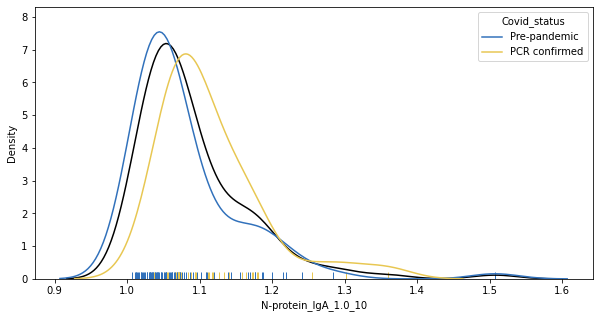

Transform: Reciprocal
Significantly different from normal distribution (< 0.05)? 2.7060588081440073e-07
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 2.708778397071028e-07


<Figure size 432x288 with 0 Axes>

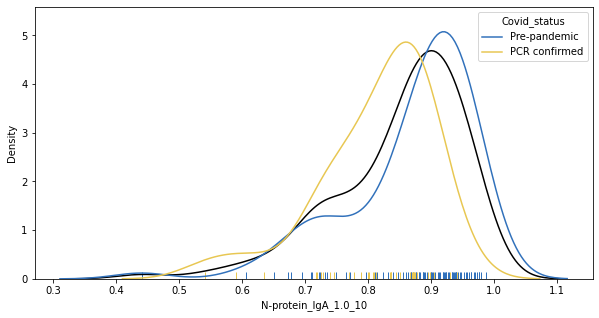

Transform: Log10
Significantly different from normal distribution (< 0.05)? 8.549186913953122e-10
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 4.7472271388015435e-09


<Figure size 432x288 with 0 Axes>

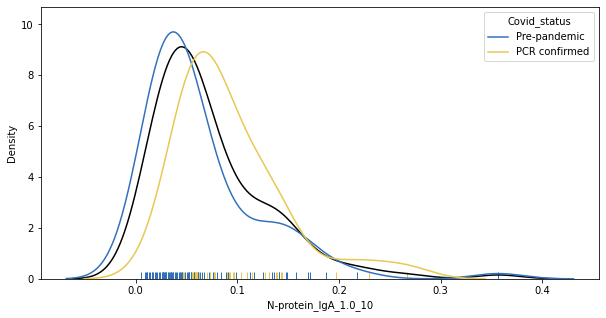

Transform: Box-Cox
Significantly different from normal distribution (< 0.05)? 0.029816951602697372
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 0.06197900116369651


<Figure size 432x288 with 0 Axes>

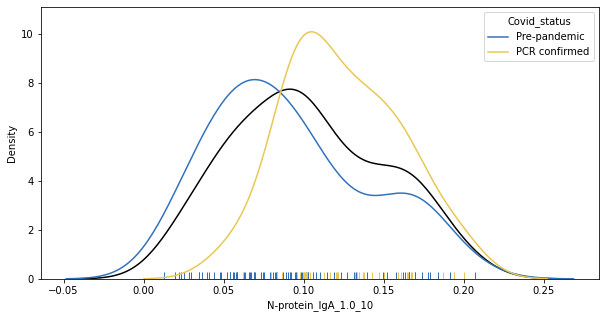




N-protein_IgG_1.0_5
Transform: Square root
Significantly different from normal distribution (< 0.05)? 8.470622884755932e-14
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 1.3387083535330426e-14


<Figure size 432x288 with 0 Axes>

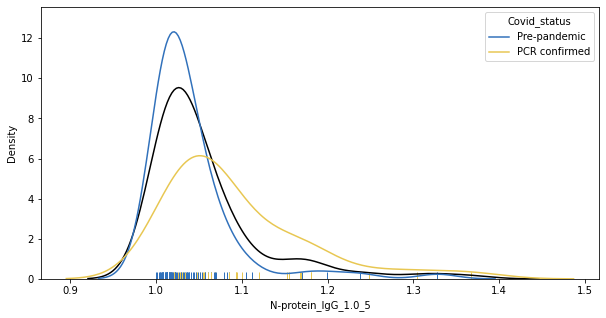

Transform: Reciprocal
Significantly different from normal distribution (< 0.05)? 1.531038837376819e-11
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 1.999249359140933e-08


<Figure size 432x288 with 0 Axes>

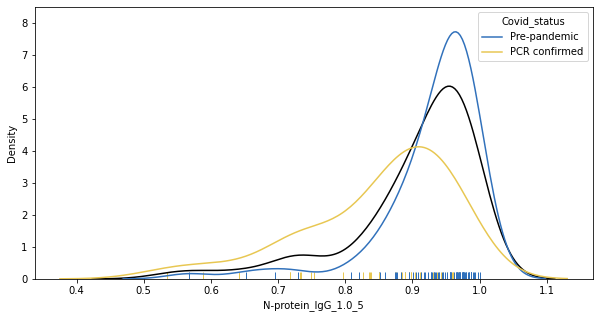

Transform: Log10
Significantly different from normal distribution (< 0.05)? 4.804012005907299e-13
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 2.44549399415285e-12


<Figure size 432x288 with 0 Axes>

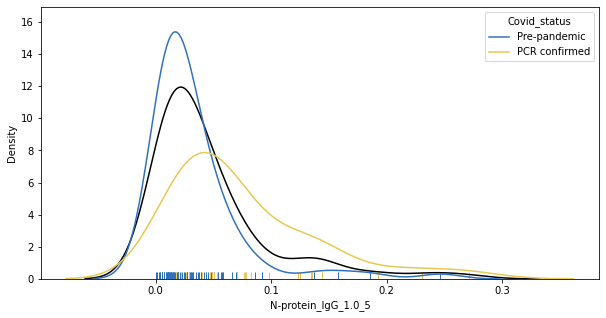

Transform: Box-Cox
Significantly different from normal distribution (< 0.05)? 0.00016151429736055434
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 0.001668156226972317


<Figure size 432x288 with 0 Axes>

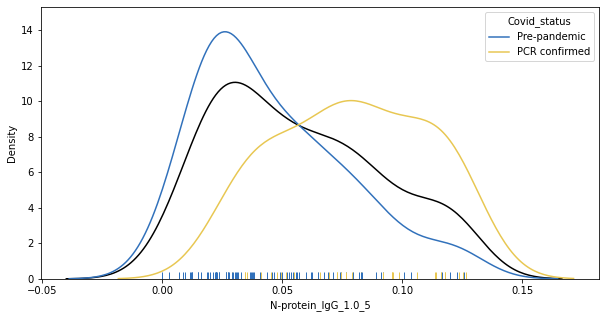




RBD_IgA_1.0_10
Transform: Square root
Significantly different from normal distribution (< 0.05)? 2.8179581477161264e-06
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 4.139211525737494e-05


<Figure size 432x288 with 0 Axes>

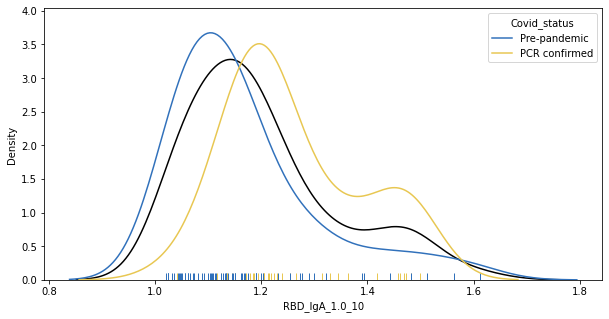

Transform: Reciprocal
Significantly different from normal distribution (< 0.05)? 0.0073879193514585495
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 0.2


<Figure size 432x288 with 0 Axes>

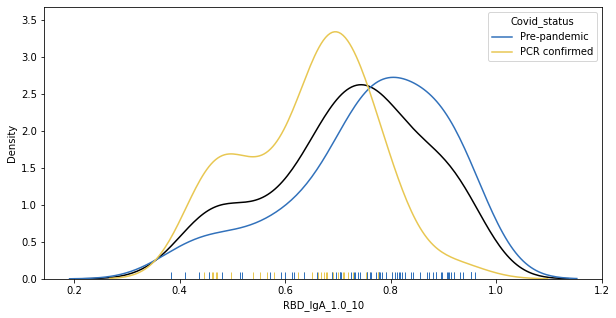

Transform: Log10
Significantly different from normal distribution (< 0.05)? 5.5752279877197e-05
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 0.0014611205428578448


<Figure size 432x288 with 0 Axes>

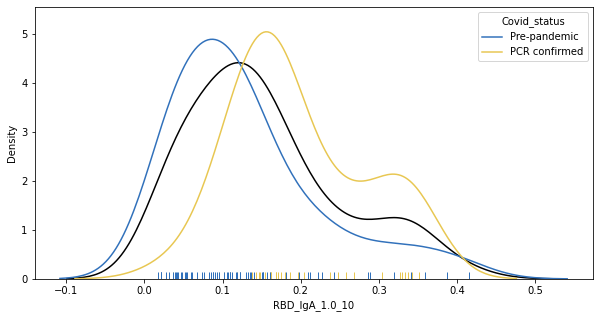

Transform: Box-Cox
Significantly different from normal distribution (< 0.05)? 0.037002526223659515
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 0.2


<Figure size 432x288 with 0 Axes>

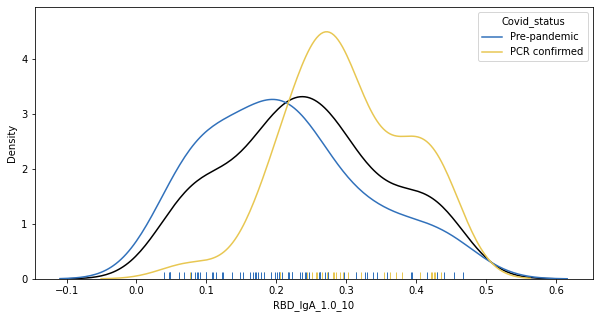




RBD_IgG_1.0_5
Transform: Square root
Significantly different from normal distribution (< 0.05)? 4.2548987266854965e-07
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 0.00035286269182522597


<Figure size 432x288 with 0 Axes>

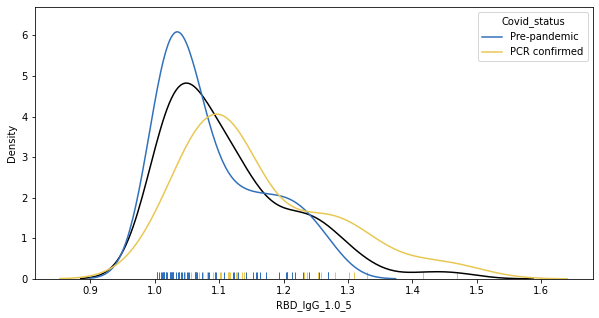

Transform: Reciprocal
Significantly different from normal distribution (< 0.05)? 0.00010567611025180668
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 0.005383678480636707


<Figure size 432x288 with 0 Axes>

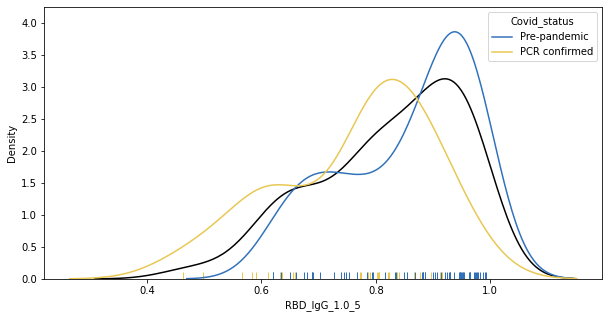

Transform: Log10
Significantly different from normal distribution (< 0.05)? 3.4924241845146753e-06
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 0.0010430249454946496


<Figure size 432x288 with 0 Axes>

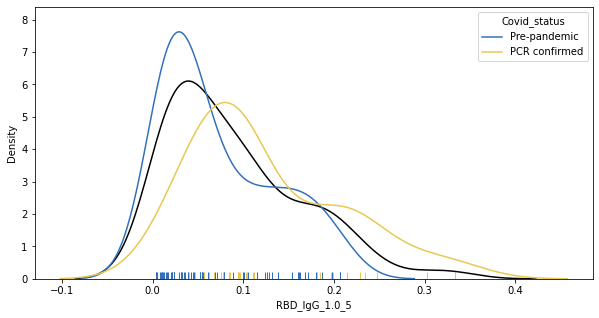

Transform: Box-Cox
Significantly different from normal distribution (< 0.05)? 0.001941094291396439
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 0.08655386982373987


<Figure size 432x288 with 0 Axes>

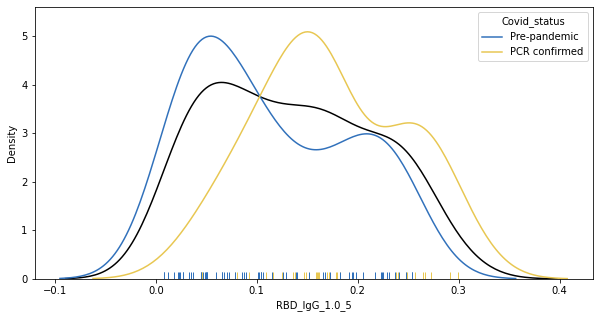




Spike_IgA_1.0_10
Transform: Square root
Significantly different from normal distribution (< 0.05)? 4.6459537605958445e-12
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 6.426961559675162e-12


<Figure size 432x288 with 0 Axes>

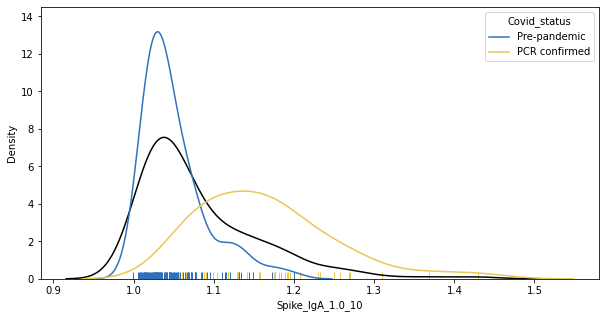

Transform: Reciprocal
Significantly different from normal distribution (< 0.05)? 4.7268411407230815e-09
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 1.3202729869550298e-07


<Figure size 432x288 with 0 Axes>

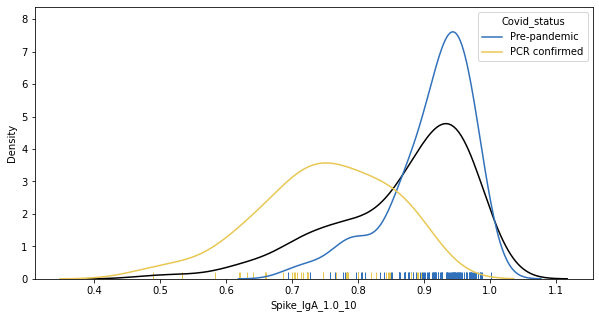

Transform: Log10
Significantly different from normal distribution (< 0.05)? 5.3991196929947805e-11
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 1.8899535622473988e-10


<Figure size 432x288 with 0 Axes>

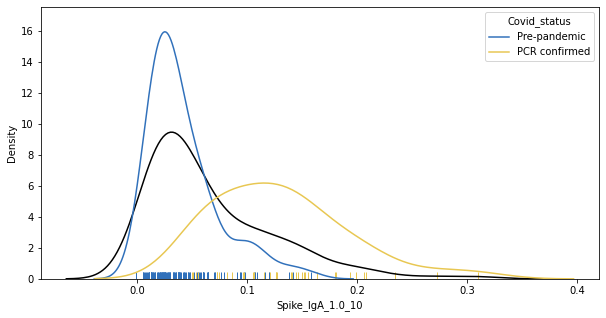

Transform: Box-Cox
Significantly different from normal distribution (< 0.05)? 9.323722042609006e-05
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 0.0040879916951019


<Figure size 432x288 with 0 Axes>

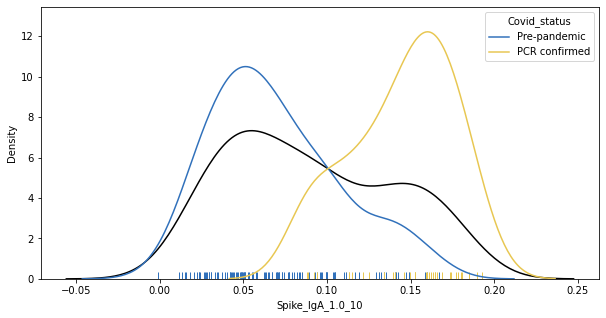




Spike_IgG_1.0_5
Transform: Square root
Significantly different from normal distribution (< 0.05)? 3.897642435581397e-15
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 5.847844363731637e-28


<Figure size 432x288 with 0 Axes>

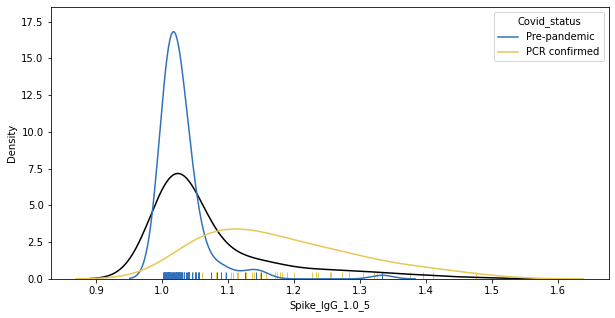

Transform: Reciprocal
Significantly different from normal distribution (< 0.05)? 3.9441805941078933e-13
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 7.709051837159274e-21


<Figure size 432x288 with 0 Axes>

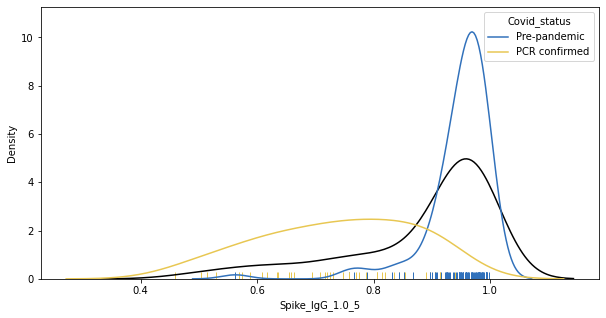

Transform: Log10
Significantly different from normal distribution (< 0.05)? 1.9325329436215878e-14
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 1.1197348775675607e-25


<Figure size 432x288 with 0 Axes>

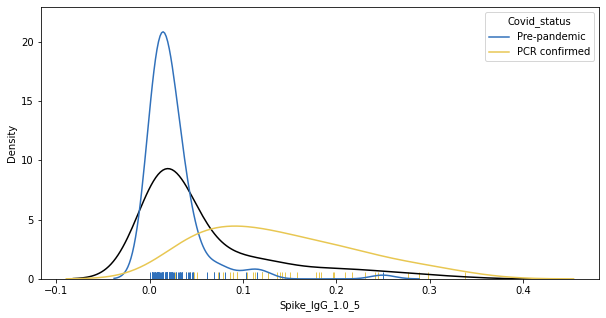

Transform: Box-Cox
Significantly different from normal distribution (< 0.05)? 1.2566601093055851e-08
Significantly different from normal distribution (Lilliefors test, p < 0.05)? 9.884210610428657e-08


<Figure size 432x288 with 0 Axes>

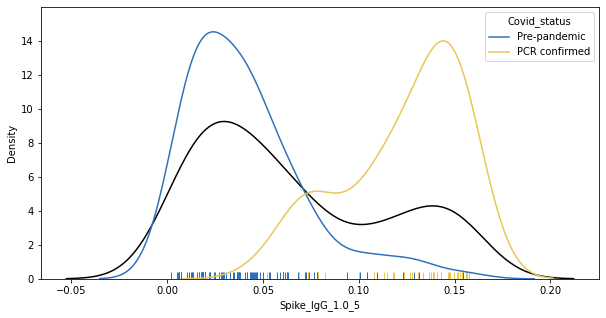

In [21]:
# Can the distribution of data for each assay be converted to a normal distribution? Unscaled data looks
# approximately lognormal.

for col in keep_dil_cols:
    print('\n\n\n{}'.format(col))
    
    for opt in ['Square root', 'Reciprocal', 'Log10', 'Box-Cox']:
        print('Transform: {}'.format(opt))

        plot_df = copy.deepcopy(reshaped_df)[[col, 'Covid_status']].dropna().reset_index(drop=True)
        if opt == 'Square root':
            plot_df[col] = np.sqrt(plot_df[col]+1)
        elif opt == 'Reciprocal':
            plot_df[col] = 1/(plot_df[col]+1)
        elif opt == 'Log10':
            plot_df[col] = np.log10(plot_df[col]+1)
        elif opt == 'Box-Cox':
            plot_df[col] = boxcox(plot_df[col]+1, lmbda=None)[0]

        shap_diff = shapiro(plot_df[col])[1]
        print('Significantly different from normal distribution (< 0.05)? {}'.format(shap_diff))
        lilliefors_diff = lilliefors(plot_df[col], 'norm')[1]
        print('Significantly different from normal distribution (Lilliefors test, p < 0.05)? {}'.format(
            lilliefors_diff
        ))

        plt.clf()
        plt.figure(figsize=(10, 5))
        sns.kdeplot(data=plot_df, x=col, color='k')
        sns.kdeplot(data=plot_df[plot_df['Covid_status']=='Pre-pandemic'], x=col, color='#3171BB')
        sns.kdeplot(data=plot_df[plot_df['Covid_status']=='PCR confirmed'], x=col, color='#E8C752')
        sns.rugplot(
            data=plot_df, x=col, hue='Covid_status', hue_order=['Pre-pandemic', 'PCR confirmed'],
            palette={'Pre-pandemic': '#3171BB', 'PCR confirmed': '#E8C752'}
        )
        plt.show()

Box-Cox transformation is the most effective, succeeds in transforming N-protein and RBD distributions to approximately normal distributions, however fails for Spike assays (not unexpected given that by eye can see from box plots and KDE plots above that Spike assays achieve the best discrimination between positive and negative samples). So, will stick to using ML algorithms that don't make assumptions about data normality in the following analysis.

In [22]:
# Scale data so values from all assays are on the same scale (to avoid issues with upweighting larger
# scales in subsequent analysis - although not a problem for tree-based algorithms, is a problem for SVM).
# Since as shown above data is not normally distributed, and is also difficult to transform to be
# approximately normal, use MinMaxScaler as opposed to any method that makes assumptions about the data
# following an approximate Gaussian distribution (such as e.g. RobustScaler)

min_max_transform = MinMaxScaler().fit(reshaped_df[keep_dil_cols])  # NaN values are disregarded in fit, included
# in transform => no need to remove prior to transformation
scaled_df = pd.DataFrame(
    min_max_transform.transform(reshaped_df[keep_dil_cols]), index=range(reshaped_df.shape[0]),
    columns=keep_dil_cols
)
scaled_df = pd.concat([scaled_df, reshaped_df[keep_disc_cols]], axis=1).reset_index(drop=True)

In [23]:
scaled_df

,N-protein_IgA_1.0_10,N-protein_IgG_1.0_5,RBD_IgA_1.0_10,RBD_IgG_1.0_5,Spike_IgA_1.0_10,Spike_IgG_1.0_5,SampleID_V,Sex,Age_years,Adult_child,Covid_symptoms,Covid_status
0,NaN,NaN,NaN,NaN,0.087984,NaN,137_V1,M,2.0,Child,NaN,Pre-pandemic
1,NaN,NaN,NaN,NaN,0.000000,0.026832,138_V1,M,2.0,Child,NaN,Pre-pandemic
2,NaN,NaN,NaN,NaN,NaN,NaN,147_V1,F,1.0,Child,NaN,Pre-pandemic
3,NaN,NaN,NaN,NaN,NaN,NaN,183_V1,F,4.0,Child,NaN,Pre-pandemic
4,NaN,NaN,NaN,NaN,NaN,NaN,190_V1,F,4.0,Child,NaN,Pre-pandemic
...,...,...,...,...,...,...,...,...,...,...,...,...
313,0.294118,0.073644,0.400488,0.058763,0.360884,0.045769,RW03_V2,F,25.0,Adult,NaN,Pre-pandemic
314,NaN,NaN,NaN,NaN,NaN,NaN,RW03_V3,F,25.0,Adult,NaN,Pre-pandemic
315,0.314854,0.252777,0.303822,0.216560,0.231626,0.083763,RW03_V4,F,25.0,Adult,NaN,Pre-pandemic
316,NaN,NaN,NaN,NaN,NaN,NaN,SS14_V3,F,23.0,Adult,NaN,Pre-pandemic


<Figure size 432x288 with 0 Axes>

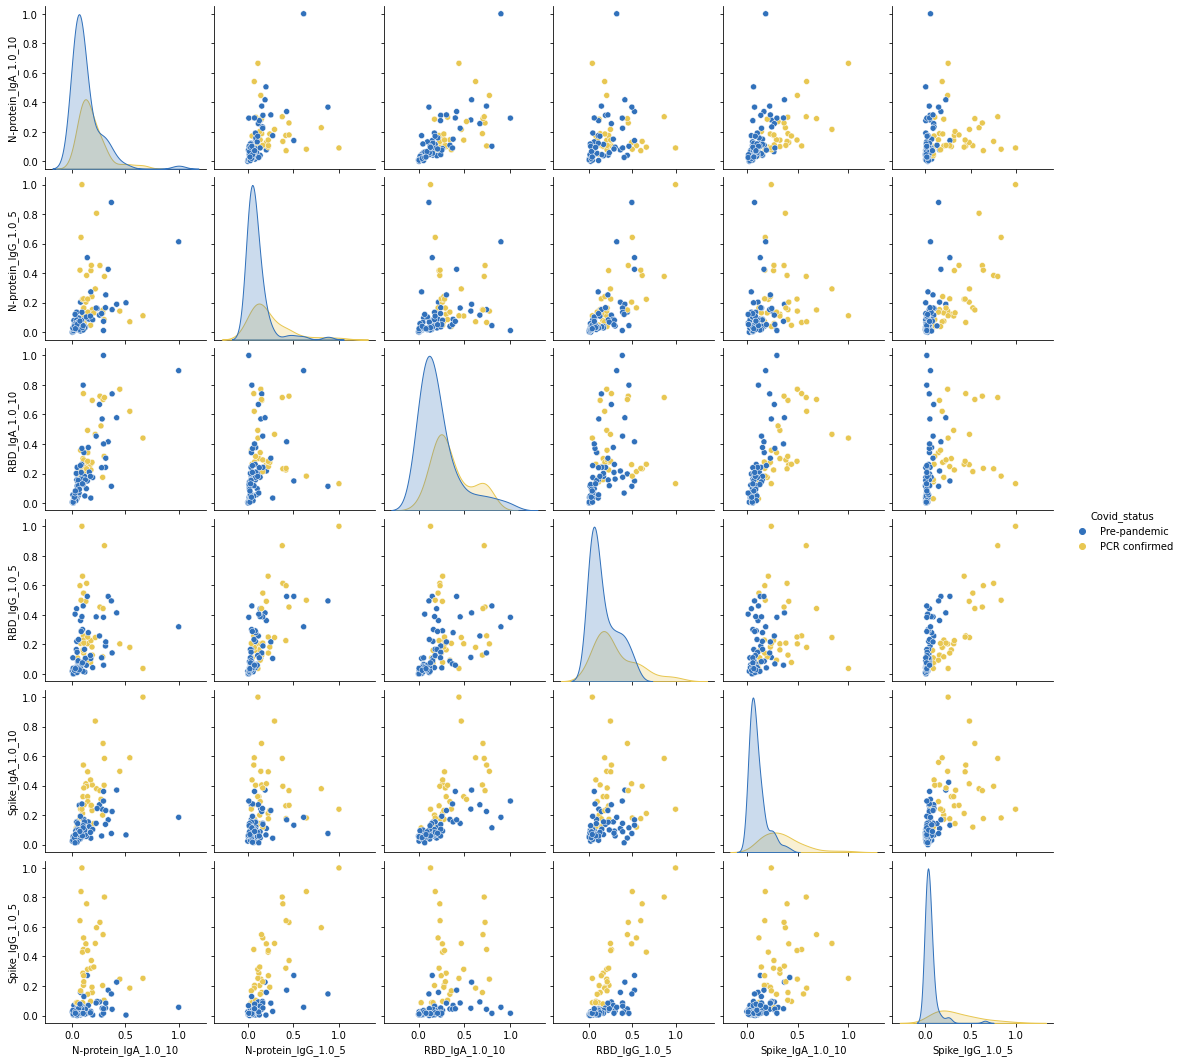

In [24]:
plt.clf()
sns.pairplot(scaled_df[keep_dil_cols + ['Covid_status']], hue='Covid_status',
             hue_order=['Pre-pandemic', 'PCR confirmed'],
             palette={'Pre-pandemic': '#3171BB', 'PCR confirmed': '#E8C752'})
plt.savefig('Saliva_assays_pairplot.svg')
plt.show()

So, by eye from pair plots above, plus the box plots and KDE plots earlier, get best discrimination between positive and negative patients with the Spike assays.

In [25]:
# Need to remove NaN samples prior to ML analysis. However, are only 32 samples with data for all assays, 96
# samples with data for all three IgA assays (115 when consider N and Spike only), and 92 samples with data
# for all three IgG assays (112 when consider N and Spike only). Are 114 samples with IgA and IgG available
# for N-protein, 93 for RBD and 130 for Spike. Note that in the paper, the RBD assays are not taken forwards
# beyond the threshold-setting stage due to poor performance.
# So, what to do? Too many blanks to fill in the gaps through e.g. impution. Will need to be selective about
# my comparisons. So, compare individual antigens to all antigens (N, RBD + Spike) with a particular secondary
# antibody, individual antigens to N and Spike (i.e. not RBD) with a particular secondary antibody, and
# individual secondary antibodies to all secondary antibodies with a particular antigen. However, do not compare
# all assays to one another at once.

filt_df = scaled_df[
    ['Spike_IgA_1.0_10', 'RBD_IgA_1.0_10', 'N-protein_IgA_1.0_10']
].dropna(axis=0).reset_index(drop=True)
print('Number of samples with data for N-protein, Spike and RBD IgA: {}'.format(filt_df.shape[0]))
filt_df = scaled_df[
    ['Spike_IgG_1.0_5', 'RBD_IgG_1.0_5', 'N-protein_IgG_1.0_5']
].dropna(axis=0).reset_index(drop=True)
print('Number of samples with data for N-protein, Spike and RBD IgG: {}'.format(filt_df.shape[0]))

filt_df = scaled_df[
    ['Spike_IgA_1.0_10', 'N-protein_IgA_1.0_10']
].dropna(axis=0).reset_index(drop=True)
print('Number of samples with data for N-protein and Spike IgA: {}'.format(filt_df.shape[0]))
filt_df = scaled_df[
    ['Spike_IgG_1.0_5', 'N-protein_IgG_1.0_5']
].dropna(axis=0).reset_index(drop=True)
print('Number of samples with data for N-protein and Spike IgG: {}'.format(filt_df.shape[0]))

filt_df = scaled_df[
    ['N-protein_IgA_1.0_10', 'N-protein_IgG_1.0_5']
].dropna(axis=0).reset_index(drop=True)
print('Number of samples with data for N-protein IgA and N-protein IgG: {}'.format(filt_df.shape[0]))
filt_df = scaled_df[
    ['RBD_IgA_1.0_10', 'RBD_IgG_1.0_5']
].dropna(axis=0).reset_index(drop=True)
print('Number of samples with data for RBD IgA and RBD IgG: {}'.format(filt_df.shape[0]))
filt_df = scaled_df[
    ['Spike_IgA_1.0_10', 'Spike_IgG_1.0_5']
].dropna(axis=0).reset_index(drop=True)
print('Number of samples with data for Spike IgA and Spike IgG: {}'.format(filt_df.shape[0]))

filt_df = scaled_df.dropna(axis=0).reset_index(drop=True)
print('Number of samples with data for all assays: {}'.format(filt_df.shape[0]))

Number of samples with data for N-protein, Spike and RBD IgA: 96
Number of samples with data for N-protein, Spike and RBD IgG: 92
Number of samples with data for N-protein and Spike IgA: 115
Number of samples with data for N-protein and Spike IgG: 112
Number of samples with data for N-protein IgA and N-protein IgG: 114
Number of samples with data for RBD IgA and RBD IgG: 93
Number of samples with data for Spike IgA and Spike IgG: 130
Number of samples with data for all assays: 32


In [26]:
assay_combs = [['N-protein_IgA_1.0_10'],
               ['RBD_IgA_1.0_10'],
               ['Spike_IgA_1.0_10'],
               ['N-protein_IgG_1.0_5'],
               ['RBD_IgG_1.0_5'],
               ['Spike_IgG_1.0_5'],
               ['N-protein_IgA_1.0_10', 'RBD_IgA_1.0_10', 'Spike_IgA_1.0_10'],
               ['N-protein_IgG_1.0_5', 'RBD_IgG_1.0_5', 'Spike_IgG_1.0_5'],
               ['N-protein_IgA_1.0_10', 'Spike_IgA_1.0_10'],
               ['N-protein_IgG_1.0_5', 'Spike_IgG_1.0_5'],
               ['N-protein_IgA_1.0_10', 'N-protein_IgG_1.0_5'],
               ['RBD_IgA_1.0_10', 'RBD_IgG_1.0_5'],
               ['Spike_IgA_1.0_10', 'Spike_IgG_1.0_5']]

['N-protein_IgA_1.0_10']
Number of samples: 115, Number pre-pandemic: 77, Number PCR confirmed: 38
{'n_estimators': 300}
{'n_estimators': 10}
{'n_estimators': 10}
{'n_estimators': 10}
{'n_estimators': 30}
['RBD_IgA_1.0_10']
Number of samples: 96, Number pre-pandemic: 62, Number PCR confirmed: 34
{'n_estimators': 10}
{'n_estimators': 1000}
{'n_estimators': 300}
{'n_estimators': 1000}
{'n_estimators': 10}
['Spike_IgA_1.0_10']
Number of samples: 150, Number pre-pandemic: 108, Number PCR confirmed: 42
{'n_estimators': 100}
{'n_estimators': 1000}
{'n_estimators': 10}
{'n_estimators': 10}
{'n_estimators': 10}
['N-protein_IgG_1.0_5']
Number of samples: 114, Number pre-pandemic: 77, Number PCR confirmed: 37
{'n_estimators': 1000}
{'n_estimators': 10}
{'n_estimators': 100}
{'n_estimators': 1000}
{'n_estimators': 10}
['RBD_IgG_1.0_5']
Number of samples: 93, Number pre-pandemic: 61, Number PCR confirmed: 32
{'n_estimators': 10}
{'n_estimators': 10}
{'n_estimators': 300}
{'n_estimators': 10}
{'n_e

<Figure size 432x288 with 0 Axes>

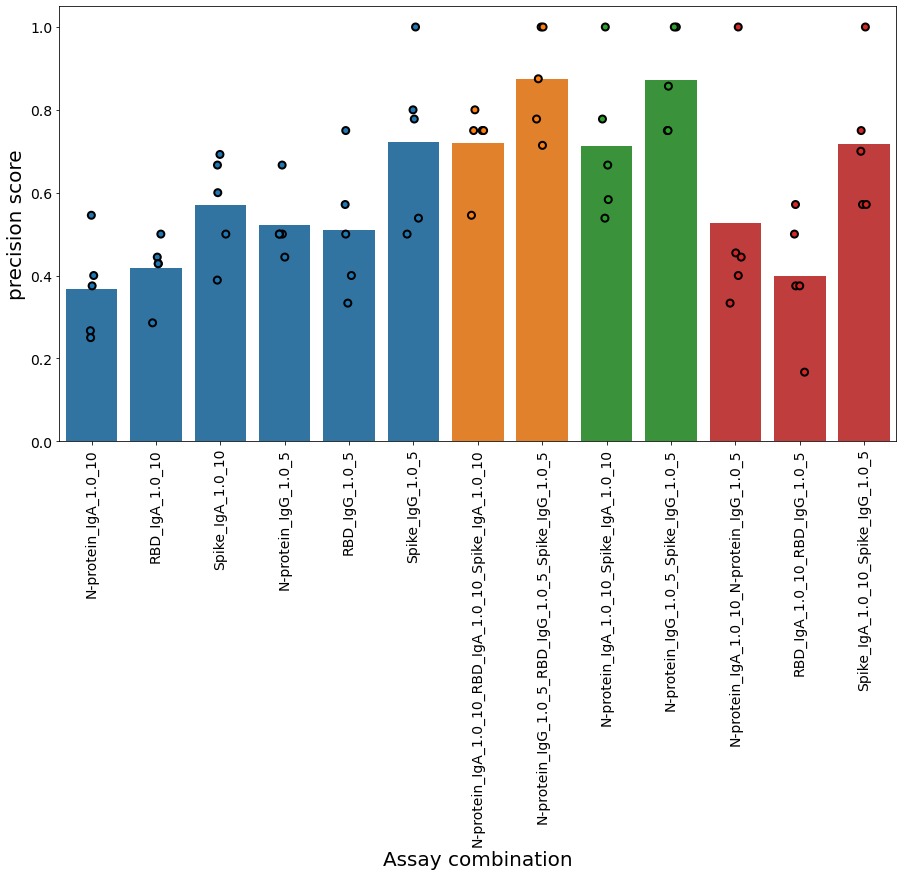




Metric: recall
                                                Assay  Mean score  \
0                                N-protein_IgA_1.0_10    0.425000   
1                                      RBD_IgA_1.0_10    0.442857   
2                                    Spike_IgA_1.0_10    0.763889   
3                                 N-protein_IgG_1.0_5    0.485714   
4                                       RBD_IgG_1.0_5    0.661905   
5                                     Spike_IgG_1.0_5    0.830556   
6   N-protein_IgA_1.0_10_RBD_IgA_1.0_10_Spike_IgA_...    0.742857   
7   N-protein_IgG_1.0_5_RBD_IgG_1.0_5_Spike_IgG_1.0_5    0.966667   
8               N-protein_IgA_1.0_10_Spike_IgA_1.0_10    0.782143   
9                 N-protein_IgG_1.0_5_Spike_IgG_1.0_5    0.839286   
10           N-protein_IgA_1.0_10_N-protein_IgG_1.0_5    0.414286   
11                       RBD_IgA_1.0_10_RBD_IgG_1.0_5    0.471429   
12                   Spike_IgA_1.0_10_Spike_IgG_1.0_5    0.950000   

    CV fold 1 s

<Figure size 432x288 with 0 Axes>

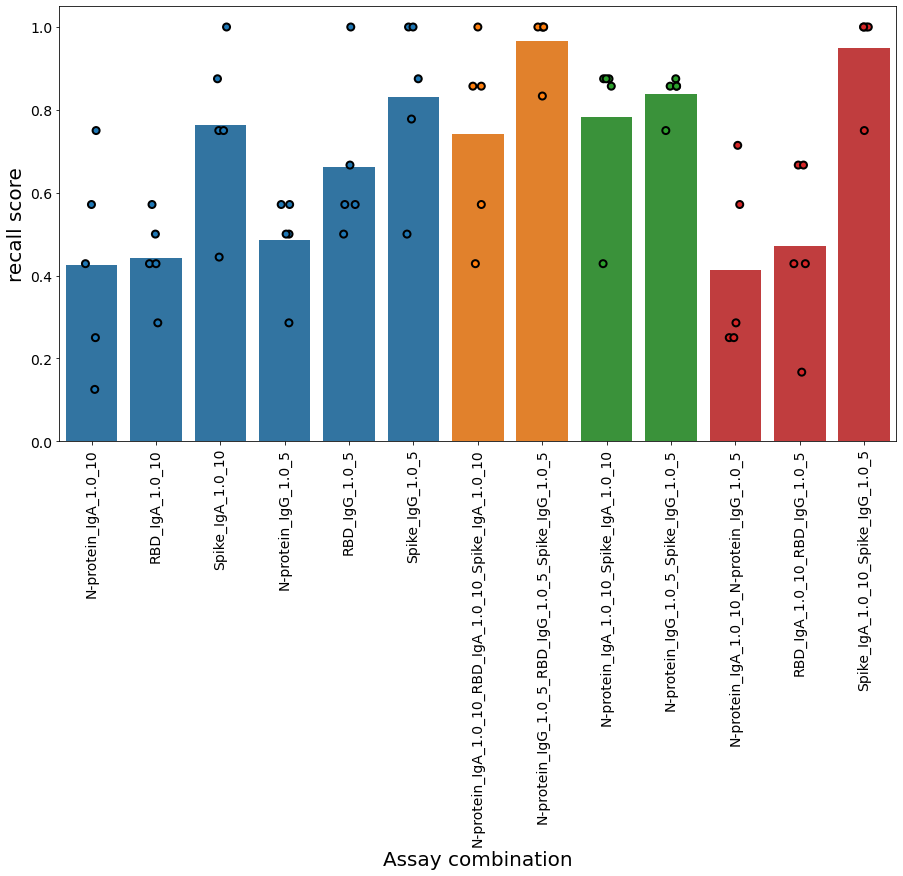




Metric: f1
                                                Assay  Mean score  \
0                                N-protein_IgA_1.0_10    0.373915   
1                                      RBD_IgA_1.0_10    0.427473   
2                                    Spike_IgA_1.0_10    0.631329   
3                                 N-protein_IgG_1.0_5    0.487451   
4                                       RBD_IgG_1.0_5    0.572834   
5                                     Spike_IgG_1.0_5    0.733333   
6   N-protein_IgA_1.0_10_RBD_IgA_1.0_10_Spike_IgA_...    0.703601   
7   N-protein_IgG_1.0_5_RBD_IgG_1.0_5_Spike_IgG_1.0_5    0.915513   
8               N-protein_IgA_1.0_10_Spike_IgA_1.0_10    0.708039   
9                 N-protein_IgG_1.0_5_Spike_IgG_1.0_5    0.851282   
10           N-protein_IgA_1.0_10_N-protein_IgG_1.0_5    0.414188   
11                       RBD_IgA_1.0_10_RBD_IgG_1.0_5    0.430696   
12                   Spike_IgA_1.0_10_Spike_IgG_1.0_5    0.805615   

    CV fold 1 score

<Figure size 432x288 with 0 Axes>

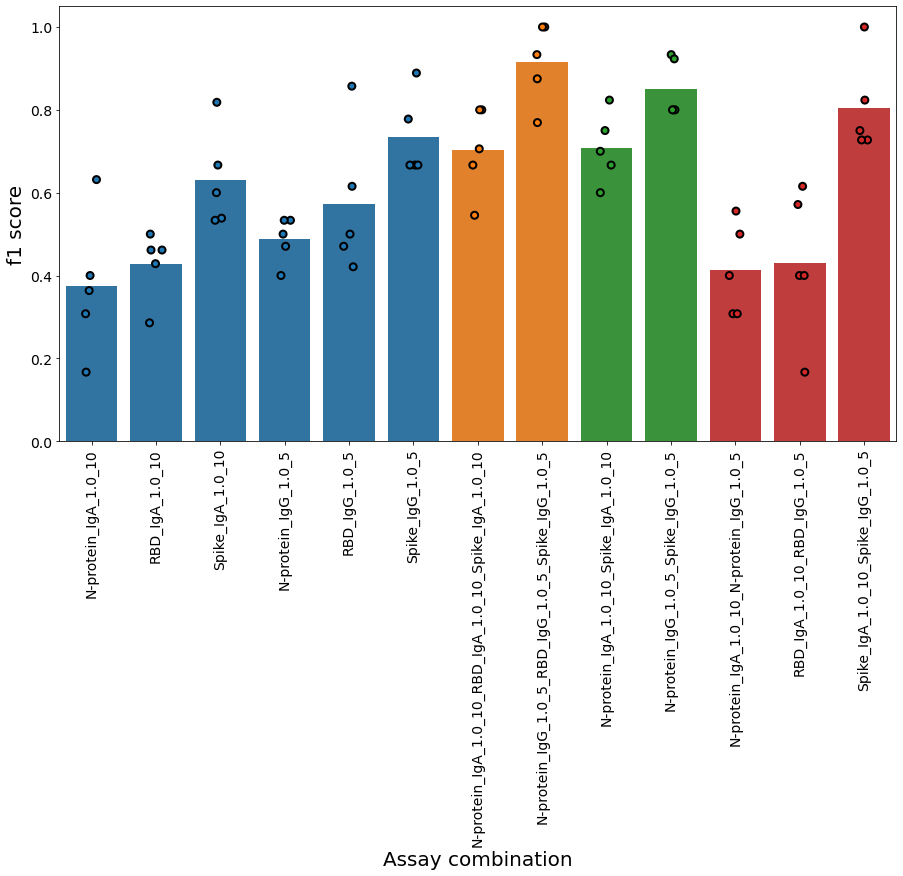




Metric: ROC AUC
                                                Assay  Mean score  \
0                                N-protein_IgA_1.0_10    0.539167   
1                                      RBD_IgA_1.0_10    0.552198   
2                                    Spike_IgA_1.0_10    0.757918   
3                                 N-protein_IgG_1.0_5    0.624940   
4                                       RBD_IgG_1.0_5    0.649542   
5                                     Spike_IgG_1.0_5    0.824225   
6   N-protein_IgA_1.0_10_RBD_IgA_1.0_10_Spike_IgA_...    0.784249   
7   N-protein_IgG_1.0_5_RBD_IgG_1.0_5_Spike_IgG_1.0_5    0.941667   
8               N-protein_IgA_1.0_10_Spike_IgA_1.0_10    0.785655   
9                 N-protein_IgG_1.0_5_Spike_IgG_1.0_5    0.886310   
10           N-protein_IgA_1.0_10_N-protein_IgG_1.0_5    0.591726   
11                       RBD_IgA_1.0_10_RBD_IgG_1.0_5    0.555586   
12                   Spike_IgA_1.0_10_Spike_IgG_1.0_5    0.881433   

    CV fold 1 

<Figure size 432x288 with 0 Axes>

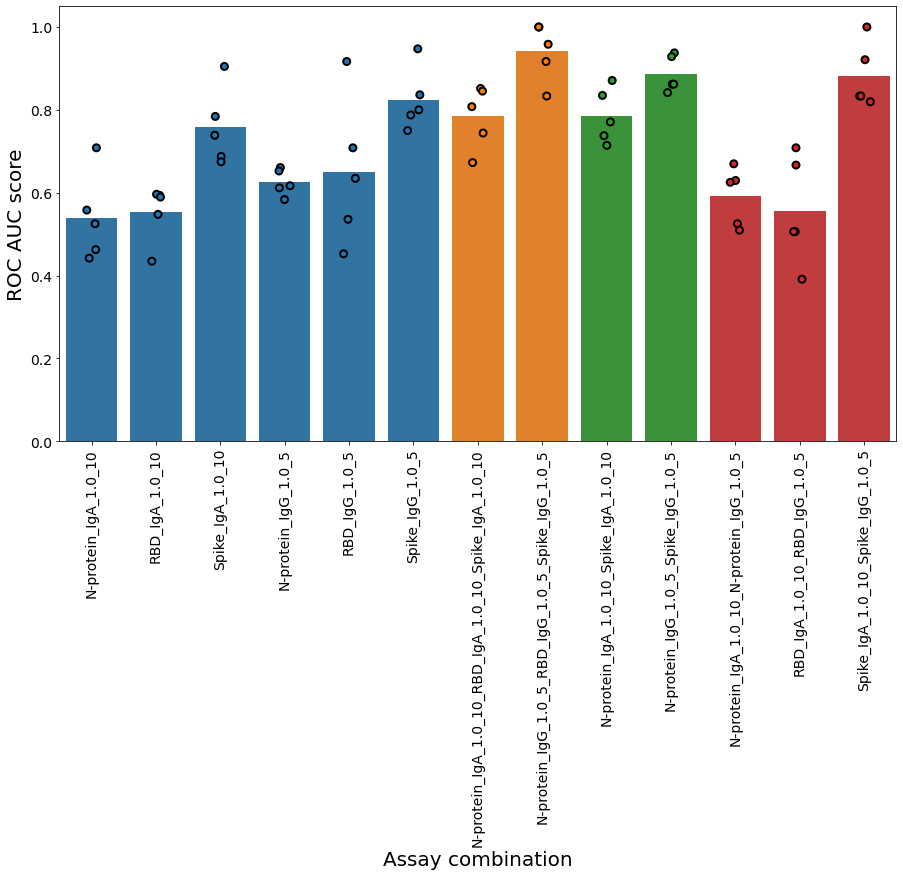

In [27]:
# Does a combination of assays allow training of a better model than any of the individual assays?
# Ada Boost classifier, optimised to maximise ROC AUC score

assay_precision_scores = {}
assay_recall_scores = {}
assay_f1_scores = {}
assay_roc_scores = {}

for assay_comb in assay_combs:
    print(assay_comb)
    assay_precision_scores['_'.join(assay_comb)] = []
    assay_recall_scores['_'.join(assay_comb)] = []
    assay_f1_scores['_'.join(assay_comb)] = []
    assay_roc_scores['_'.join(assay_comb)] = []

    # To avoid any leakage between the training and test dataset, perform scaling as part of the CV loop
    filt_df = copy.deepcopy(reshaped_df)[assay_comb + ['Covid_status']].dropna().reset_index(drop=True)
    filt_df['Covid_status'] = [0 if filt_df['Covid_status'][n] == 'Pre-pandemic'
                               else 1 for n in range(filt_df.shape[0])]
    print('Number of samples: {}, Number pre-pandemic: {}, Number PCR confirmed: {}'.format(
        filt_df.shape[0], filt_df['Covid_status'].tolist().count(0), filt_df['Covid_status'].tolist().count(1)
    ))

    # 5-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    splits = skf.split(X=filt_df[assay_comb], y=filt_df['Covid_status'].tolist())

    for split in splits:
        train_set = filt_df.iloc[list(split[0])]
        test_set = filt_df.iloc[list(split[1])]
        train_x = train_set[assay_comb]
        train_y = train_set['Covid_status'].tolist()
        test_x = test_set[assay_comb]
        test_y = test_set['Covid_status'].tolist()
        
        # Scale data
        train_x_vals = MinMaxScaler().fit_transform(train_x)
        test_x_vals = MinMaxScaler().fit_transform(test_x)
        train_x = pd.DataFrame(train_x_vals, columns=train_x.columns)
        test_x = pd.DataFrame(test_x_vals, columns=test_x.columns)
        
        # Grid search to find optimal parameters
        ada_boost = AdaBoostClassifier()
        parameters = {'n_estimators': [10, 30, 100, 300, 1000]}
        grid_search = GridSearchCV(
            estimator=ada_boost, param_grid=parameters, error_score=np.nan, scoring='roc_auc'
        )
        grid_search.fit(X=train_x, y=train_y)
        print(grid_search.best_params_)
        
        # Train model with optimal parameters
        ada_boost = AdaBoostClassifier(**grid_search.best_params_)
        ada_boost.fit(train_x, train_y)
        # Test model
        predictions = ada_boost.predict(test_x)
        precision = precision_score(test_y, predictions, zero_division=0)
        assay_precision_scores['_'.join(assay_comb)].append(precision)
        recall = recall_score(test_y, predictions, zero_division=0)
        assay_recall_scores['_'.join(assay_comb)].append(recall)
        f1 = f1_score(test_y, predictions, zero_division=0)
        assay_f1_scores['_'.join(assay_comb)].append(f1)
        roc = roc_auc_score(test_y, predictions)
        assay_roc_scores['_'.join(assay_comb)].append(roc)

for metric, assay_comb_scores in {'precision': assay_precision_scores,
                                  'recall': assay_recall_scores,
                                  'f1': assay_f1_scores,
                                  'ROC AUC': assay_roc_scores}.items():
    print('\n\n\nMetric: {}'.format(metric))
    
    assay_x = []
    score_y = []
    hue = []
    mean_score_y = []
    mean_hue = []
    for assay_comb, score_list in assay_comb_scores.items():
        mean_score_y.append(np.mean(score_list))
        if len(assay_comb.split('_')) == 4:
            mean_hue.append('tab:blue')
        elif len(assay_comb.split('_')) == 12:
            mean_hue.append('tab:orange')
        elif len(assay_comb.split('_')) == 8:
            if all(x in assay_comb for x in ['IgG', 'IgA']):
                mean_hue.append('tab:red')
            else:
                mean_hue.append('tab:green')

        for score in score_list:
            assay_x.append(assay_comb)
            score_y.append(score)
            if len(assay_comb.split('_')) == 4:
                hue.append('tab:blue')
            elif len(assay_comb.split('_')) == 12:
                hue.append('tab:orange')
            elif len(assay_comb.split('_')) == 8:
                if all(x in assay_comb for x in ['IgG', 'IgA']):
                    hue.append('tab:red')
                else:
                    hue.append('tab:green')
    
    score_df = pd.DataFrame({'Assay': assay_comb_scores.keys(),
                             'Mean score': mean_score_y,
                             'CV fold 1 score': [score_list[0] for score_list in assay_comb_scores.values()],
                             'CV fold 2 score': [score_list[1] for score_list in assay_comb_scores.values()],
                             'CV fold 3 score': [score_list[2] for score_list in assay_comb_scores.values()],
                             'CV fold 4 score': [score_list[3] for score_list in assay_comb_scores.values()],
                             'CV fold 5 score': [score_list[4] for score_list in assay_comb_scores.values()]})
    score_df.to_pickle('AdaBoost_5-fold_CV_{}.pkl'.format(metric))
    with pd.option_context('display.max_columns', 7):
        pprint.PrettyPrinter().pprint(score_df)

    plt.clf()
    plt.figure(figsize=(15, 8))
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Assay combination', fontsize=20)
    plt.ylabel('{} score'.format(metric), fontsize=20)
    g1 = sns.barplot(x=list(assay_comb_scores.keys()), y=mean_score_y, hue=mean_hue, dodge=False)
    g1.legend_.remove()
    g2 = sns.stripplot(x=assay_x, y=score_y, hue=hue, edgecolor='k', linewidth=2, size=7, jitter=True, dodge=False)
    g2.legend_.remove()
    plt.savefig('AdaBoost_5-fold_CV_{}_barplot.svg'.format(metric))
    plt.show()

In [28]:
# Is the difference in performance between individual and multiple assays significant?
    
class ManualFeatureSelection(BaseEstimator, TransformerMixin):
    """
    """

    def __init__(self, sel_feat):
        """
        """

        self.sel_feat = sel_feat

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        """
        """

        X_vals = MinMaxScaler().fit_transform(X)
        X = pd.DataFrame(X_vals, columns=X.columns)
        X = X[self.sel_feat]
        return X


def train_clf(clf, x, y, sel_col):
    transform_and_sel_feat = ManualFeatureSelection(sel_feat=sel_col)
    clf = Pipeline([('transform_and_select_features', transform_and_sel_feat),
                    (type(clf).__name__, clf)])
    clf.fit(X=x, y=y)
    return clf


comp_assays = [[['N-protein_IgA_1.0_10'], ['N-protein_IgA_1.0_10', 'RBD_IgA_1.0_10', 'Spike_IgA_1.0_10']],
               [['RBD_IgA_1.0_10'], ['N-protein_IgA_1.0_10', 'RBD_IgA_1.0_10', 'Spike_IgA_1.0_10']],
               [['Spike_IgA_1.0_10'], ['N-protein_IgA_1.0_10', 'RBD_IgA_1.0_10', 'Spike_IgA_1.0_10']],
               [['N-protein_IgG_1.0_5'], ['N-protein_IgG_1.0_5', 'RBD_IgG_1.0_5', 'Spike_IgG_1.0_5']],
               [['RBD_IgG_1.0_5'], ['N-protein_IgG_1.0_5', 'RBD_IgG_1.0_5', 'Spike_IgG_1.0_5']],
               [['Spike_IgG_1.0_5'], ['N-protein_IgG_1.0_5', 'RBD_IgG_1.0_5', 'Spike_IgG_1.0_5']],
               [['N-protein_IgA_1.0_10'], ['N-protein_IgA_1.0_10', 'Spike_IgA_1.0_10']],
               [['Spike_IgA_1.0_10'], ['N-protein_IgA_1.0_10', 'Spike_IgA_1.0_10']],
               [['N-protein_IgG_1.0_5'], ['N-protein_IgG_1.0_5', 'Spike_IgG_1.0_5']],
               [['Spike_IgG_1.0_5'], ['N-protein_IgG_1.0_5', 'Spike_IgG_1.0_5']],
               [['N-protein_IgA_1.0_10'], ['N-protein_IgA_1.0_10', 'N-protein_IgG_1.0_5']],
               [['RBD_IgA_1.0_10'], ['RBD_IgA_1.0_10', 'RBD_IgG_1.0_5']],
               [['Spike_IgA_1.0_10'], ['Spike_IgA_1.0_10', 'Spike_IgG_1.0_5']],
               [['N-protein_IgG_1.0_5'], ['N-protein_IgA_1.0_10', 'N-protein_IgG_1.0_5']],
               [['RBD_IgG_1.0_5'], ['RBD_IgA_1.0_10', 'RBD_IgG_1.0_5']],
               [['Spike_IgG_1.0_5'], ['Spike_IgA_1.0_10', 'Spike_IgG_1.0_5']]]

filt_df = copy.deepcopy(reshaped_df)[keep_dil_cols + ['Covid_status']].dropna().reset_index(drop=True)
ada_boost = AdaBoostClassifier()
parameters = {'n_estimators': [10, 30, 100, 300, 1000]}
grid_search = GridSearchCV(
    estimator=ada_boost, param_grid=parameters, error_score=np.nan, scoring='roc_auc'
)
grid_search.fit(X=filt_df.drop(['Covid_status'], axis=1),
                y=filt_df['Covid_status'])
print(grid_search.best_params_)

for comb in comp_assays:
    cols_1 = comb[0]
    cols_2 = comb[1]
    print('{},   {}'.format(cols_1, cols_2))

    filt_df = copy.deepcopy(reshaped_df)[cols_2 + ['Covid_status']].dropna().reset_index(drop=True)
    filt_df['Covid_status'] = [0 if filt_df['Covid_status'][n] == 'Pre-pandemic'
                               else 1 for n in range(filt_df.shape[0])]
    
    clf_1 = train_clf(AdaBoostClassifier(**grid_search.best_params_), filt_df.drop(['Covid_status'], axis=1),
                      filt_df['Covid_status'], cols_1)
    clf_2 = train_clf(AdaBoostClassifier(**grid_search.best_params_), filt_df.drop(['Covid_status'], axis=1),
                      filt_df['Covid_status'], cols_2)

    F, p = combined_ftest_5x2cv(estimator1=clf_1,
                                estimator2=clf_2,
                                X=filt_df.drop(['Covid_status'], axis=1),
                                y=filt_df['Covid_status'],
                                scoring='roc_auc')
    print('Significant difference between {} and {}?\nF = {}; p = {}\n\n'.format(cols_1, cols_2, F, p))

{'n_estimators': 1000}
['N-protein_IgA_1.0_10'],   ['N-protein_IgA_1.0_10', 'RBD_IgA_1.0_10', 'Spike_IgA_1.0_10']
Significant difference between ['N-protein_IgA_1.0_10'] and ['N-protein_IgA_1.0_10', 'RBD_IgA_1.0_10', 'Spike_IgA_1.0_10']?
F = 14.776075117191663; p = 0.004137880258840012


['RBD_IgA_1.0_10'],   ['N-protein_IgA_1.0_10', 'RBD_IgA_1.0_10', 'Spike_IgA_1.0_10']
Significant difference between ['RBD_IgA_1.0_10'] and ['N-protein_IgA_1.0_10', 'RBD_IgA_1.0_10', 'Spike_IgA_1.0_10']?
F = 16.9559654582883; p = 0.0029998626173222613


['Spike_IgA_1.0_10'],   ['N-protein_IgA_1.0_10', 'RBD_IgA_1.0_10', 'Spike_IgA_1.0_10']
Significant difference between ['Spike_IgA_1.0_10'] and ['N-protein_IgA_1.0_10', 'RBD_IgA_1.0_10', 'Spike_IgA_1.0_10']?
F = 1.4506943583653011; p = 0.3571727254515799


['N-protein_IgG_1.0_5'],   ['N-protein_IgG_1.0_5', 'RBD_IgG_1.0_5', 'Spike_IgG_1.0_5']
Significant difference between ['N-protein_IgG_1.0_5'] and ['N-protein_IgG_1.0_5', 'RBD_IgG_1.0_5', 'Spike_IgG_1.0_

Need to be very careful about selecting a particular p value theshold to reject a difference between assay performance as "significant" or not, since have performed multiple tests (e.g. if were to use a threshold of p = 0.05, by chance 1 in 20 times would expect p to be below 0.05 by chance - if perform multiple assays, the chance of at least one of these being below 0.05 is greater than 1 in 20). Conversely, since the datasets I am working with are small (from an ML perspective), this will make it difficult to detect all but the largest differences as "significant", as can be seen when comparing the graphs above to the 5x2 CV F-test scores here.

Regardless, when look at the graphs above in combination with the test results here, I draw the following conclusions:
- Achieve best performance with N, RBD + Spike IgG. The performance of these three assays in combination exceeds that of the individual assays. Leaving out RBD from this combination leads to a slight decrease in performance, but this difference may well be due to random chance.
- Combination of N, RBD and Spike IgA assays is little/no better than Spike IgA on its own.
- Combining Spike IgA and IgG leads to a small improvement in performance as compared to Spike IgG on its own.

['N-protein_IgA_1.0_10']
Number of samples: 115, Number pre-pandemic: 77, Number PCR confirmed: 38
{'C': 0.1, 'dual': False}
{'C': 0.1, 'dual': False}
{'C': 0.1, 'dual': False}
{'C': 0.1, 'dual': False}
{'C': 0.1, 'dual': False}
['RBD_IgA_1.0_10']
Number of samples: 96, Number pre-pandemic: 62, Number PCR confirmed: 34
{'C': 0.1, 'dual': False}
{'C': 0.1, 'dual': False}
{'C': 0.1, 'dual': False}
{'C': 0.1, 'dual': False}
{'C': 0.1, 'dual': False}
['Spike_IgA_1.0_10']
Number of samples: 150, Number pre-pandemic: 108, Number PCR confirmed: 42
{'C': 0.1, 'dual': False}
{'C': 0.1, 'dual': False}
{'C': 0.1, 'dual': False}
{'C': 0.1, 'dual': False}
{'C': 0.1, 'dual': False}
['N-protein_IgG_1.0_5']
Number of samples: 114, Number pre-pandemic: 77, Number PCR confirmed: 37
{'C': 0.1, 'dual': False}
{'C': 0.1, 'dual': False}
{'C': 0.1, 'dual': False}
{'C': 0.1, 'dual': False}
{'C': 0.1, 'dual': False}
['RBD_IgG_1.0_5']
Number of samples: 93, Number pre-pandemic: 61, Number PCR confirmed: 32
{'C'

<Figure size 432x288 with 0 Axes>

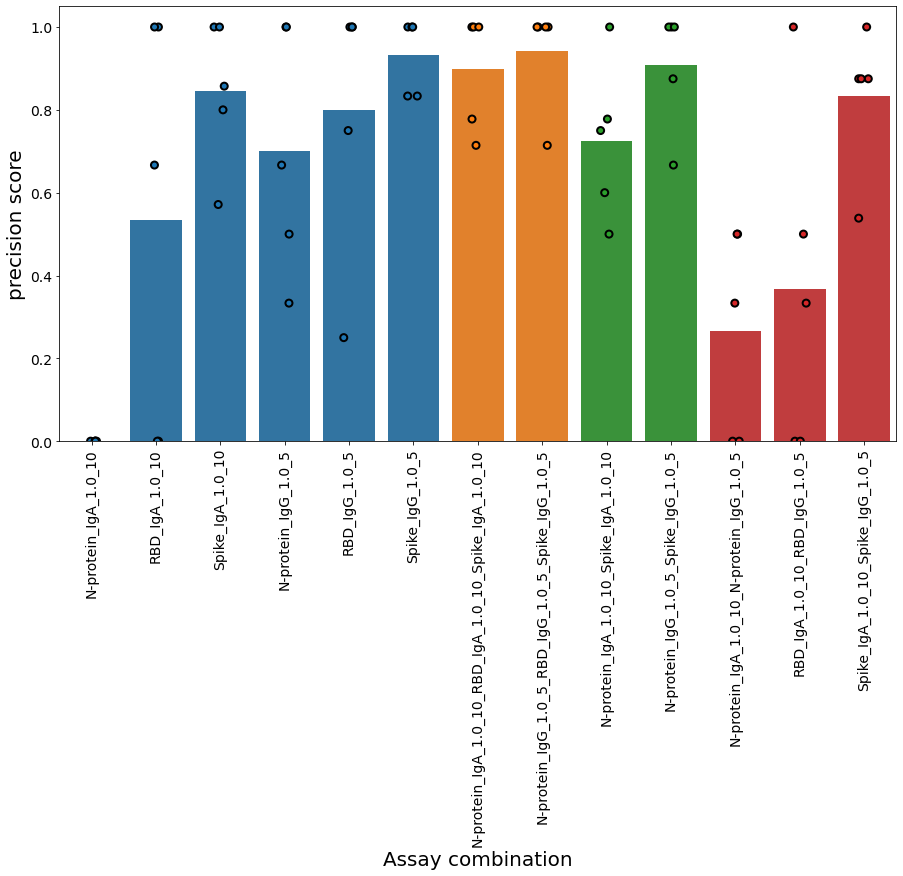




Metric: recall
                                                Assay  Mean score  \
0                                N-protein_IgA_1.0_10    0.000000   
1                                      RBD_IgA_1.0_10    0.152381   
2                                    Spike_IgA_1.0_10    0.422222   
3                                 N-protein_IgG_1.0_5    0.160714   
4                                       RBD_IgG_1.0_5    0.214286   
5                                     Spike_IgG_1.0_5    0.491667   
6   N-protein_IgA_1.0_10_RBD_IgA_1.0_10_Spike_IgA_...    0.709524   
7   N-protein_IgG_1.0_5_RBD_IgG_1.0_5_Spike_IgG_1.0_5    0.904762   
8               N-protein_IgA_1.0_10_Spike_IgA_1.0_10    0.742857   
9                 N-protein_IgG_1.0_5_Spike_IgG_1.0_5    0.789286   
10           N-protein_IgA_1.0_10_N-protein_IgG_1.0_5    0.142857   
11                       RBD_IgA_1.0_10_RBD_IgG_1.0_5    0.161905   
12                   Spike_IgA_1.0_10_Spike_IgG_1.0_5    0.850000   

    CV fold 1 s

<Figure size 432x288 with 0 Axes>

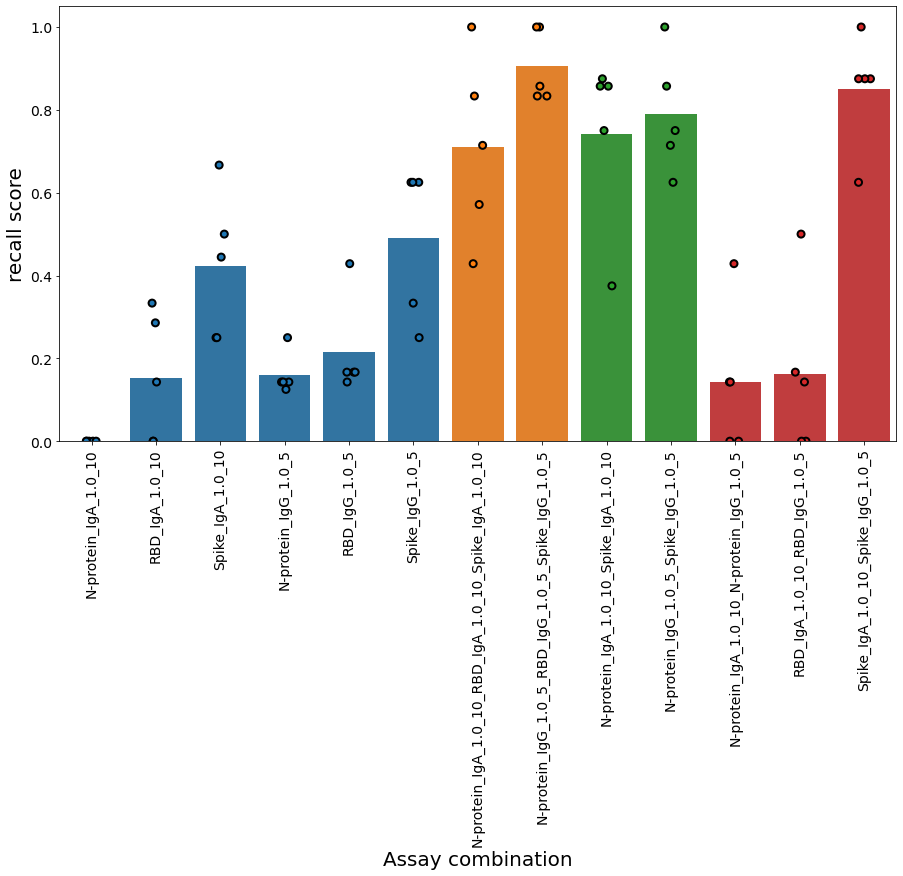




Metric: f1
                                                Assay  Mean score  \
0                                N-protein_IgA_1.0_10    0.000000   
1                                      RBD_IgA_1.0_10    0.230000   
2                                    Spike_IgA_1.0_10    0.533077   
3                                 N-protein_IgG_1.0_5    0.252727   
4                                       RBD_IgG_1.0_5    0.313377   
5                                     Spike_IgG_1.0_5    0.619560   
6   N-protein_IgA_1.0_10_RBD_IgA_1.0_10_Spike_IgA_...    0.765130   
7   N-protein_IgG_1.0_5_RBD_IgG_1.0_5_Spike_IgG_1.0_5    0.920280   
8               N-protein_IgA_1.0_10_Spike_IgA_1.0_10    0.693446   
9                 N-protein_IgG_1.0_5_Spike_IgG_1.0_5    0.832971   
10           N-protein_IgA_1.0_10_N-protein_IgG_1.0_5    0.176752   
11                       RBD_IgA_1.0_10_RBD_IgG_1.0_5    0.223333   
12                   Spike_IgA_1.0_10_Spike_IgG_1.0_5    0.818846   

    CV fold 1 score

<Figure size 432x288 with 0 Axes>

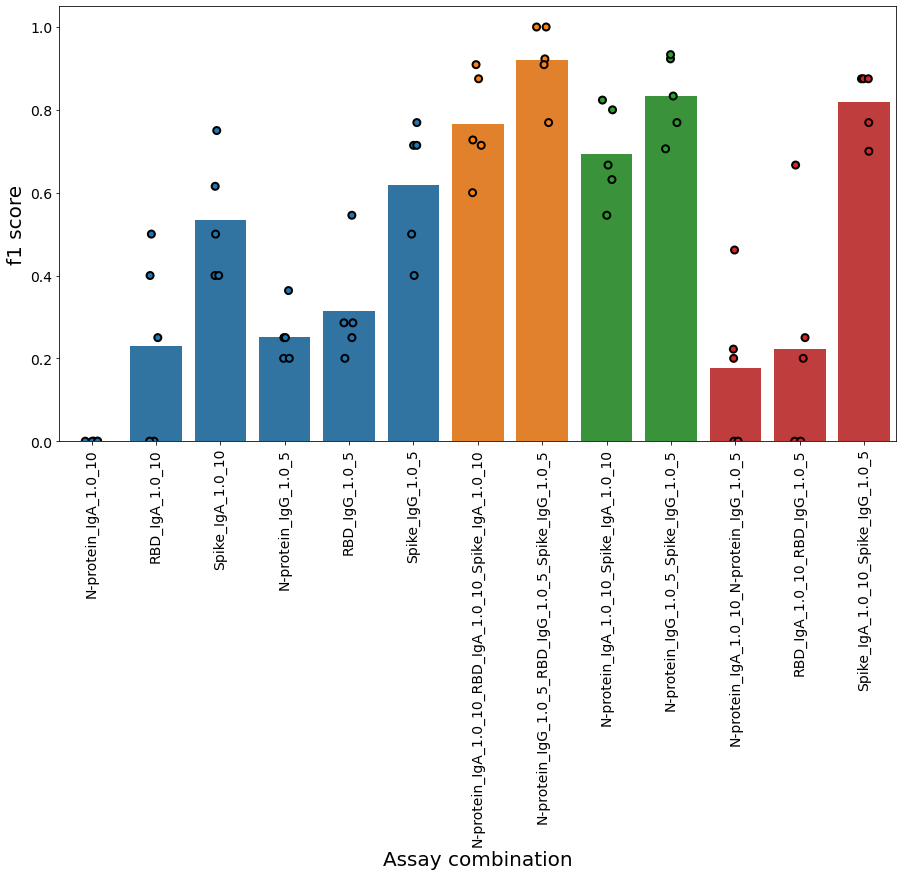




Metric: ROC AUC
                                                Assay  Mean score  \
0                                N-protein_IgA_1.0_10    0.487500   
1                                      RBD_IgA_1.0_10    0.542857   
2                                    Spike_IgA_1.0_10    0.687518   
3                                 N-protein_IgG_1.0_5    0.553690   
4                                       RBD_IgG_1.0_5    0.575733   
5                                     Spike_IgG_1.0_5    0.735570   
6   N-protein_IgA_1.0_10_RBD_IgA_1.0_10_Spike_IgA_...    0.821429   
7   N-protein_IgG_1.0_5_RBD_IgG_1.0_5_Spike_IgG_1.0_5    0.935714   
8               N-protein_IgA_1.0_10_Spike_IgA_1.0_10    0.781429   
9                 N-protein_IgG_1.0_5_Spike_IgG_1.0_5    0.867976   
10           N-protein_IgA_1.0_10_N-protein_IgG_1.0_5    0.519345   
11                       RBD_IgA_1.0_10_RBD_IgG_1.0_5    0.539927   
12                   Spike_IgA_1.0_10_Spike_IgG_1.0_5    0.876754   

    CV fold 1 

<Figure size 432x288 with 0 Axes>

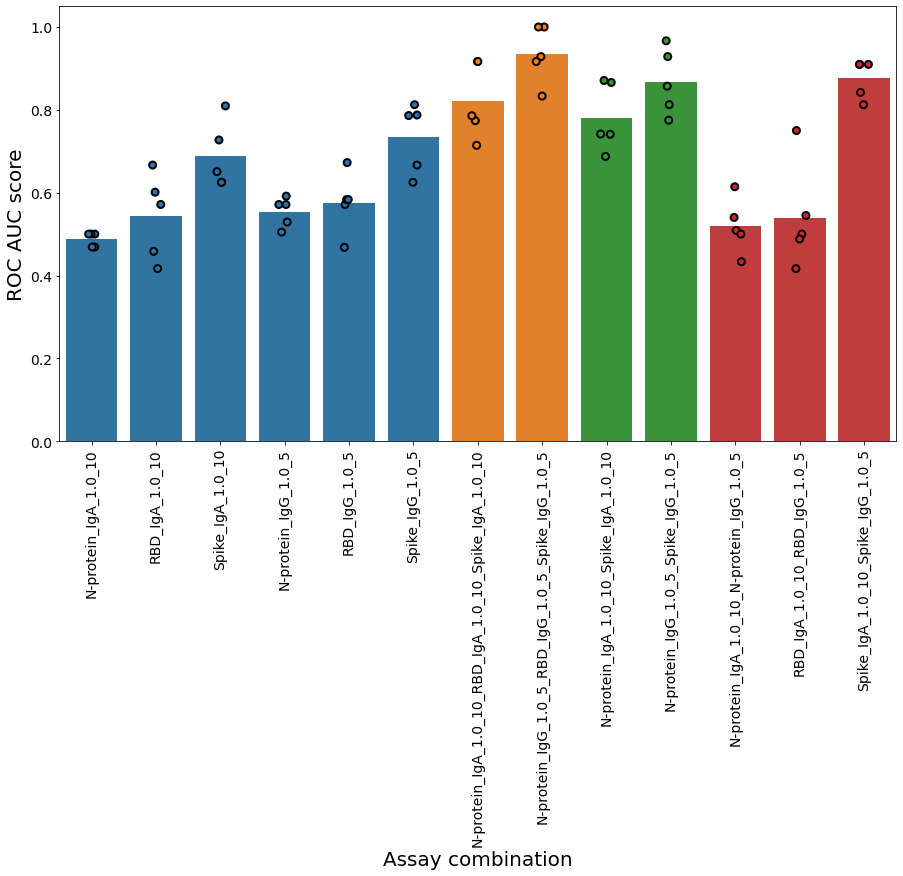

In [29]:
# Does a combination of assays allow training of a better model than any of the individual assays?
# Support vector classifier, linear kernel, optimised to maximise ROC AUC score

assay_precision_scores = {}
assay_recall_scores = {}
assay_f1_scores = {}
assay_roc_scores = {}

for assay_comb in assay_combs:
    print(assay_comb)
    assay_precision_scores['_'.join(assay_comb)] = []
    assay_recall_scores['_'.join(assay_comb)] = []
    assay_f1_scores['_'.join(assay_comb)] = []
    assay_roc_scores['_'.join(assay_comb)] = []

    filt_df = copy.deepcopy(reshaped_df)[assay_comb + ['Covid_status']].dropna().reset_index(drop=True)
    filt_df['Covid_status'] = [0 if filt_df['Covid_status'][n] == 'Pre-pandemic'
                               else 1 for n in range(filt_df.shape[0])]
    print('Number of samples: {}, Number pre-pandemic: {}, Number PCR confirmed: {}'.format(
        filt_df.shape[0], filt_df['Covid_status'].tolist().count(0), filt_df['Covid_status'].tolist().count(1)
    ))

    # 5-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    splits = skf.split(X=filt_df[assay_comb], y=filt_df['Covid_status'].tolist())

    for split in splits:
        train_set = filt_df.iloc[list(split[0])]
        test_set = filt_df.iloc[list(split[1])]
        train_x = train_set[assay_comb]
        train_y = train_set['Covid_status'].tolist()
        test_x = test_set[assay_comb]
        test_y = test_set['Covid_status'].tolist()
        
        # Scale data
        train_x_vals = MinMaxScaler().fit_transform(train_x)
        test_x_vals = MinMaxScaler().fit_transform(test_x)
        train_x = pd.DataFrame(train_x_vals, columns=train_x.columns)
        test_x = pd.DataFrame(test_x_vals, columns=test_x.columns)
        
        # Grid search to find optimal parameters
        svc = LinearSVC()
        parameters = {'C': np.logspace(-1, 5, num=7, base=10),
                      'dual': [False]}
        grid_search = GridSearchCV(
            estimator=svc, param_grid=parameters, error_score=np.nan, scoring='roc_auc'
        )
        grid_search.fit(X=train_x, y=train_y)
        print(grid_search.best_params_)
        
        # Train model with optimal parameters
        svc = LinearSVC(**grid_search.best_params_)
        svc.fit(train_x, train_y)
        # Test model
        predictions = svc.predict(test_x)
        precision = precision_score(test_y, predictions, zero_division=0)
        assay_precision_scores['_'.join(assay_comb)].append(precision)
        recall = recall_score(test_y, predictions, zero_division=0)
        assay_recall_scores['_'.join(assay_comb)].append(recall)
        f1 = f1_score(test_y, predictions, zero_division=0)
        assay_f1_scores['_'.join(assay_comb)].append(f1)
        roc = roc_auc_score(test_y, predictions)
        assay_roc_scores['_'.join(assay_comb)].append(roc)

for metric, assay_comb_scores in {'precision': assay_precision_scores,
                                  'recall': assay_recall_scores,
                                  'f1': assay_f1_scores,
                                  'ROC AUC': assay_roc_scores}.items():
    print('\n\n\nMetric: {}'.format(metric))
    
    assay_x = []
    score_y = []
    hue = []
    mean_score_y = []
    mean_hue = []
    for assay_comb, score_list in assay_comb_scores.items():
        mean_score_y.append(np.mean(score_list))
        if len(assay_comb.split('_')) == 4:
            mean_hue.append('tab:blue')
        elif len(assay_comb.split('_')) == 12:
            mean_hue.append('tab:orange')
        elif len(assay_comb.split('_')) == 8:
            if all(x in assay_comb for x in ['IgG', 'IgA']):
                mean_hue.append('tab:red')
            else:
                mean_hue.append('tab:green')

        for score in score_list:
            assay_x.append(assay_comb)
            score_y.append(score)
            if len(assay_comb.split('_')) == 4:
                hue.append('tab:blue')
            elif len(assay_comb.split('_')) == 12:
                hue.append('tab:orange')
            elif len(assay_comb.split('_')) == 8:
                if all(x in assay_comb for x in ['IgG', 'IgA']):
                    hue.append('tab:red')
                else:
                    hue.append('tab:green')
                
    score_df = pd.DataFrame({'Assay': assay_comb_scores.keys(),
                             'Mean score': mean_score_y,
                             'CV fold 1 score': [score_list[0] for score_list in assay_comb_scores.values()],
                             'CV fold 2 score': [score_list[1] for score_list in assay_comb_scores.values()],
                             'CV fold 3 score': [score_list[2] for score_list in assay_comb_scores.values()],
                             'CV fold 4 score': [score_list[3] for score_list in assay_comb_scores.values()],
                             'CV fold 5 score': [score_list[4] for score_list in assay_comb_scores.values()]})
    score_df.to_pickle('LinearSVC_5-fold_CV_{}.pkl'.format(metric))
    with pd.option_context('display.max_columns', 7):
        pprint.PrettyPrinter().pprint(score_df)

    plt.clf()
    plt.figure(figsize=(15, 8))
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Assay combination', fontsize=20)
    plt.ylabel('{} score'.format(metric), fontsize=20)
    g1 = sns.barplot(x=list(assay_comb_scores.keys()), y=mean_score_y, hue=mean_hue, dodge=False)
    g1.legend_.remove()
    g2 = sns.stripplot(x=assay_x, y=score_y, hue=hue, edgecolor='k', linewidth=2, size=7, jitter=True, dodge=False)
    g2.legend_.remove()
    plt.savefig('LinearSVC_5-fold_CV_{}_barplot.svg'.format(metric))
    plt.show()

In [30]:
# Is the difference in performance between individual and multiple assays significant?

filt_df = copy.deepcopy(reshaped_df)[keep_dil_cols + ['Covid_status']].dropna().reset_index(drop=True)
svc = LinearSVC()
parameters = {'C': np.logspace(-1, 5, num=7, base=10),
              'dual': [False]}
grid_search = GridSearchCV(
    estimator=svc, param_grid=parameters, error_score=np.nan, scoring='roc_auc'
)
grid_search.fit(X=filt_df.drop(['Covid_status'], axis=1),
                y=filt_df['Covid_status'])
print(grid_search.best_params_)

for comb in comp_assays:
    cols_1 = comb[0]
    cols_2 = comb[1]
    print('{},   {}'.format(cols_1, cols_2))

    filt_df = copy.deepcopy(reshaped_df)[cols_2 + ['Covid_status']].dropna().reset_index(drop=True)
    filt_df['Covid_status'] = [0 if filt_df['Covid_status'][n] == 'Pre-pandemic'
                               else 1 for n in range(filt_df.shape[0])]

    clf_1 = train_clf(LinearSVC(**grid_search.best_params_), filt_df.drop(['Covid_status'], axis=1),
                      filt_df['Covid_status'], cols_1)
    clf_2 = train_clf(LinearSVC(**grid_search.best_params_), filt_df.drop(['Covid_status'], axis=1),
                      filt_df['Covid_status'], cols_2)

    F, p = combined_ftest_5x2cv(estimator1=clf_1,
                                estimator2=clf_2,
                                X=filt_df.drop(['Covid_status'], axis=1),
                                y=filt_df['Covid_status'],
                                scoring='roc_auc')
    print('Significant difference between {} and {}?\nF = {}; p = {}\n\n'.format(cols_1, cols_2, F, p))

{'C': 10.0, 'dual': False}
['N-protein_IgA_1.0_10'],   ['N-protein_IgA_1.0_10', 'RBD_IgA_1.0_10', 'Spike_IgA_1.0_10']
Significant difference between ['N-protein_IgA_1.0_10'] and ['N-protein_IgA_1.0_10', 'RBD_IgA_1.0_10', 'Spike_IgA_1.0_10']?
F = 26.55865528884772; p = 0.001032678108384505


['RBD_IgA_1.0_10'],   ['N-protein_IgA_1.0_10', 'RBD_IgA_1.0_10', 'Spike_IgA_1.0_10']
Significant difference between ['RBD_IgA_1.0_10'] and ['N-protein_IgA_1.0_10', 'RBD_IgA_1.0_10', 'Spike_IgA_1.0_10']?
F = 1.1212785903605529; p = 0.47836695197008056


['Spike_IgA_1.0_10'],   ['N-protein_IgA_1.0_10', 'RBD_IgA_1.0_10', 'Spike_IgA_1.0_10']
Significant difference between ['Spike_IgA_1.0_10'] and ['N-protein_IgA_1.0_10', 'RBD_IgA_1.0_10', 'Spike_IgA_1.0_10']?
F = 0.8430994173240297; p = 0.6187558018216563


['N-protein_IgG_1.0_5'],   ['N-protein_IgG_1.0_5', 'RBD_IgG_1.0_5', 'Spike_IgG_1.0_5']
Significant difference between ['N-protein_IgG_1.0_5'] and ['N-protein_IgG_1.0_5', 'RBD_IgG_1.0_5', 'Spike_IgG_1

Results from LinearSVC are similar to the AdaBoost results.

So, to summarise, both the AdaBoost and LinearSVC models achieve best performance when combining the three IgG assays. Combining the Spike IgA and IgG assays also achieves good performance, but the improvement as compared to the individual assays is less pronounced (and hence I am less confident that this difference is real).




['N-protein_IgA_1.0_10', 'RBD_IgA_1.0_10', 'Spike_IgA_1.0_10']


<Figure size 432x288 with 0 Axes>

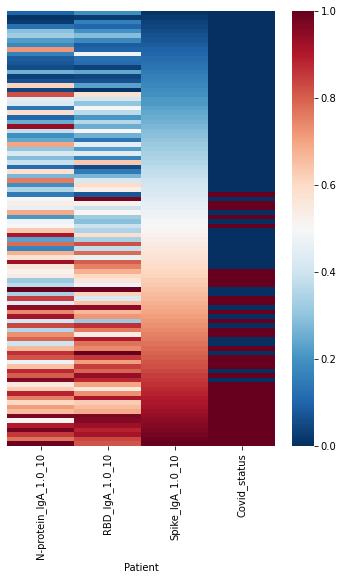




['N-protein_IgG_1.0_5', 'RBD_IgG_1.0_5', 'Spike_IgG_1.0_5']


<Figure size 432x288 with 0 Axes>

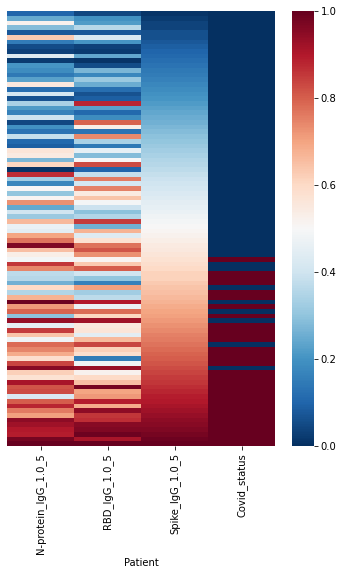




['N-protein_IgA_1.0_10', 'Spike_IgA_1.0_10']


<Figure size 432x288 with 0 Axes>

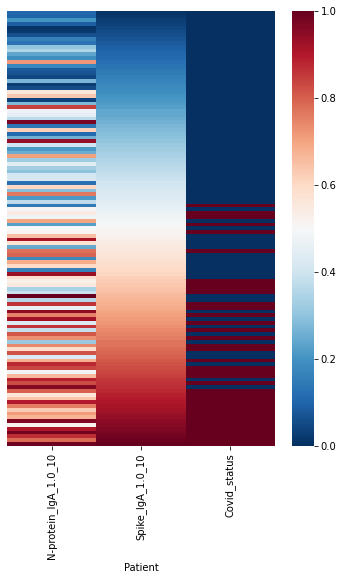




['N-protein_IgG_1.0_5', 'Spike_IgG_1.0_5']


<Figure size 432x288 with 0 Axes>

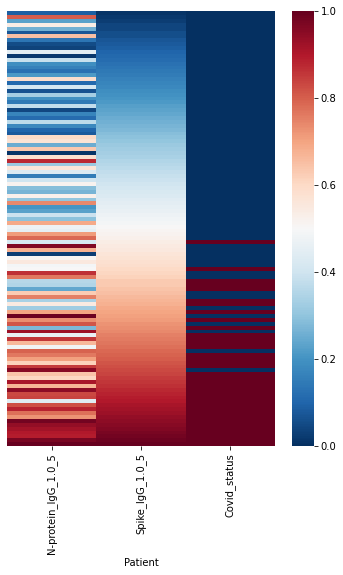




['N-protein_IgA_1.0_10', 'N-protein_IgG_1.0_5']


<Figure size 432x288 with 0 Axes>

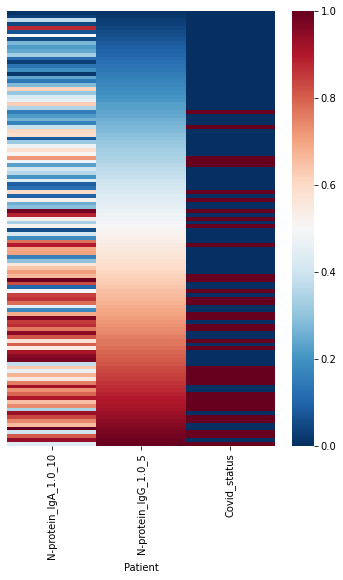




['RBD_IgA_1.0_10', 'RBD_IgG_1.0_5']


<Figure size 432x288 with 0 Axes>

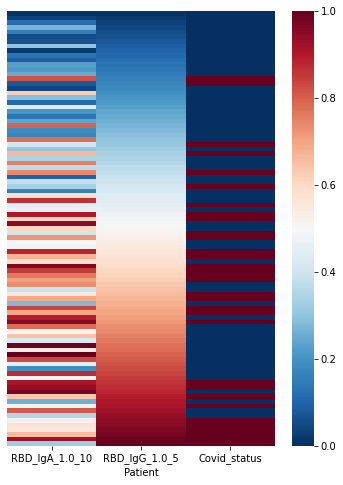




['Spike_IgA_1.0_10', 'Spike_IgG_1.0_5']


<Figure size 432x288 with 0 Axes>

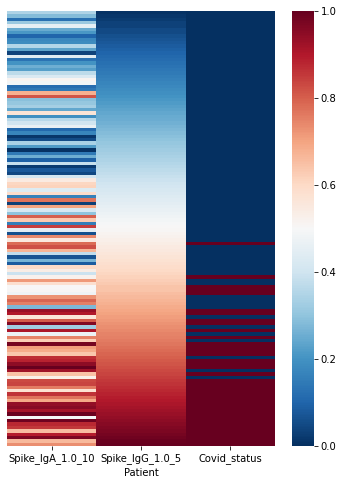

In [31]:
# Do the different assays rank the patients similarly?
rank_dfs = {}

sub_assay_combs = [['N-protein_IgA_1.0_10', 'RBD_IgA_1.0_10', 'Spike_IgA_1.0_10'],
                   ['N-protein_IgG_1.0_5', 'RBD_IgG_1.0_5', 'Spike_IgG_1.0_5'],
                   ['N-protein_IgA_1.0_10', 'Spike_IgA_1.0_10'],
                   ['N-protein_IgG_1.0_5', 'Spike_IgG_1.0_5'],
                   ['N-protein_IgA_1.0_10', 'N-protein_IgG_1.0_5'],
                   ['RBD_IgA_1.0_10', 'RBD_IgG_1.0_5'],
                   ['Spike_IgA_1.0_10', 'Spike_IgG_1.0_5']]

for comb in sub_assay_combs:
    print('\n\n\n{}'.format(comb))
    filt_df = copy.deepcopy(reshaped_df)[comb + ['Covid_status']].dropna().reset_index(drop=True)
    filt_df['Covid_status'] = [0 if filt_df['Covid_status'][n] == 'Pre-pandemic'
                               else 1 for n in range(filt_df.shape[0])]

    for col in comb:
        filt_df[col] = filt_df[col].rank()/filt_df.shape[0]
    # Sort by last assay in list
    filt_df = filt_df.sort_values(by=comb[-1])
    filt_df = filt_df.reset_index(drop=True)

    plt.clf()
    plt.figure(figsize=(6, 8))
    plt.ylabel('Normalised rank')
    sns.heatmap(filt_df, cmap='RdBu_r', yticklabels=False)
    plt.show()

So, as seen in other plots above, Spike assays, in particular the Spike IgG assay, show the best discrimination between positive and negative samples. The agreement between the three antigens is fairly good, especially in the case of IgG, which makes sense since as can be seen from previous plots these assays perform better - for the same reason, the greater agreement between the two Spike assays as compared to between the two assays for each of the other antigens makes sense. There is also slightly better agreement between Spike and RBD than they show with N-protein; again this makes sense as RBD is a subdomain of Spike.